# **ELIXIR Spatial Transcriptomics Course**

Author: George Gavriilidis

Date: 2025-02-22

Author email: ggeorav@certh.gr

# Practical 2: Quality Control and Visualisation for Sequence-based data analysis

### Quiz: Pre-Workshop Check


1. What is the importance of QC metrics on spatial data?

2. Evaluating library size - why?

3. Thresholding across various QC metrics - how to decide?

4. Cells per spot - why does it matter?

5. Mitochondria - what do they represent for QC?

6. Normalisation - why do we need that for downstream analysis?

7. Spotting Highly Variable Genes - does it matter and how QC is important?

8. What are some advanced visualisations that `SpatialData` can facilitate for sequence-based analysis?

Take a moment to reflect on these questions before moving on to the hands-on exercises.


# Dependencies

In [3]:
from spatialdata_io import visium, visium_hd, xenium

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [4]:
import spatialdata as sd
import spatialdata_plot as sdp
from spatialdata_io import visium, visium_hd, xenium
import matplotlib.pyplot as plt  # for multi-panel plots later

In [5]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import issparse

In [9]:
sc.settings.verbosity = 3

# 2.0 Load Visium dataset

The dataset used here consists of a Visium slide of a coronal section of the mouse brain. The original dataset is publicly available at the 10x Genomics dataset portal <https://support.10xgenomics.com/spatial-gene-expression/datasets>_ 

In [10]:
import scanpy as sc

# Define the path to the organized Visium data directory
visium_data_path = "/data/spatial_workshop/day1/practical_0/visium_coronal"


# Read the Visium data into an AnnData object
adata = sc.read_visium(visium_data_path, count_file="V1_Adult_Mouse_Brain_raw_feature_bc_matrix.h5")

# Display basic information about the AnnData object
print(adata)

reading /data/spatial_workshop/day1/practical_0/visium_coronal/V1_Adult_Mouse_Brain_raw_feature_bc_matrix.h5
 (0:00:01)


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4992 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# 2.1 Spot-level Quality Control

In [11]:
# An R implementation of these analytical steps can pe found in the following URL: https://bookdown.org/sjcockell/ismb-tutorial-2023/

## Introduction to Spot-Level Quality Control (sQC)

Quality control (QC) is essential for analyzing high-throughput molecular biology data. Removing noise and low-quality data from complex datasets enhances the reliability of downstream analyses. Spatial transcriptomics (STx) is no exception, with QC typically performed at two main levels: **spot-level** and **gene-level**. This document focuses on **spot-level QC**.

### Spot-Level Quality Control (sQC)

Spot-level QC eliminates low-quality spots prior to analysis. These low-quality spots can result from issues during library preparation or experimental procedures, such as:
- **High percentage of dead cells** due to cell damage during library preparation.
- **Low mRNA capture efficiency** caused by ineffective reverse transcription or PCR amplification.

Keeping low-quality spots can introduce noise and compromise the accuracy of downstream analyses.

### Characteristics of Low-Quality Spots

Low-quality spots are identified using criteria similar to those used in cell-level QC for single-cell RNA sequencing (scRNA-seq) data:
- **Library size**: Total UMI counts per spot may vary due to sequencing or the number of cells in the spot.
- **Number of expressed genes**: The number of genes with non-zero UMI counts per spot.
- **Proportion of mitochondrial reads**: A high proportion indicates potential cell damage.

#### Key Indicators:
1. **Low Library Size / Expressed Features**:
   - Reflects poor mRNA capture rates due to cell damage or low reaction efficiency.
2. **High Mitochondrial Proportion**:
   - Indicates cell damage, e.g., partial lysis, leading to cytoplasmic mRNA leakage and a higher concentration of relatively protected mitochondrial mRNAs.
3. **Unusually High Cell Numbers per Spot**:
   - May indicate problems during cell segmentation.

### Relevance of scRNA-seq QC Metrics in STx

The use of scRNA-seq QC metrics in STx data is based on the similarity between datasets. When spatial information is ignored, each spot can be treated as a single cell. However, STx spots differ from scRNA-seq cells because they may contain zero, one, or multiple cells, leading to distinct distributions for high-quality spots compared to high-quality cells in scRNA-seq.

## 2.1.1 Plot tissue map

Initially, we will try to get a sense of the data by plotting High-Resolution Image with Spatial Coordinates Overlay

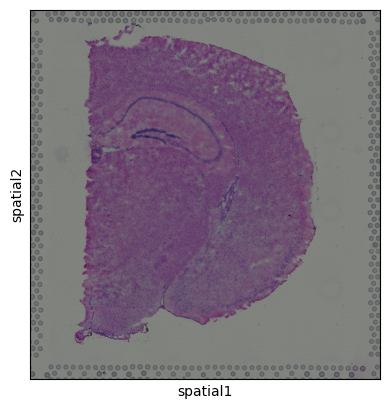

In [12]:
# Plot spatial coordinates without annotations
sc.pl.spatial(adata, color=None, size=1.5)

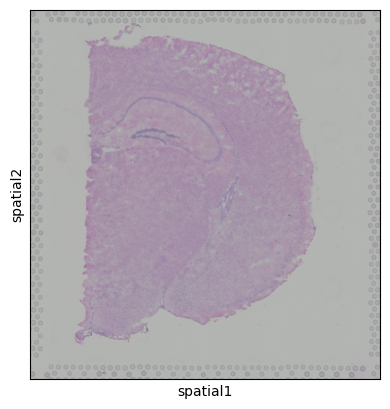

In [13]:
import scanpy as sc

# Overlay spatial coordinates on the tissue image
sc.pl.spatial(
    adata,
    color=None,       # No color (default spots)
    size=1.5,         # Adjust spot size
    img_key="hires",  # Use the high-resolution image
    alpha_img=0.6     # Adjust image transparency
)

At present, the dataset contains both on- and off-tissue spots - we plotted these in the previous practical. For any future analysis though we are only interested in the on-tissue spots. Therefore, before we run any calculations we want to remove the off-tissue spots

## 2.1.2 Calculating QC metrics

In [14]:
# Display dataset dimensions before filtering
print(f"Dataset dimensions before filtering: {adata.shape}")

# Filter to include only on-tissue spots
adata = adata[adata.obs['in_tissue'] == 1]

# Display dataset dimensions after filtering
print(f"Dataset dimensions after filtering: {adata.shape}")

Dataset dimensions before filtering: (4992, 32285)
Dataset dimensions after filtering: (2702, 32285)


In [15]:
# Print the first 20 gene names in your dataset
print("First 20 gene names in the dataset:")
print(adata.var_names[:20].tolist())

# Detect mitochondrial genes using alternative prefixes
mito_genes_alt = adata.var_names.str.contains("(^MT-)|(^mt-)|(^mt\\-)", regex=True)
print(f"Number of mitochondrial genes detected: {mito_genes_alt.sum()}")

# Extract and print the names of mitochondrial genes
mito_genes_list = adata.var_names[mito_genes_alt]
print("Mitochondrial genes detected:")
print(mito_genes_list.tolist())

First 20 gene names in the dataset:
['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Gm16041', 'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', '4732440D04Rik', 'Alkal1', 'St18']
Number of mitochondrial genes detected: 13
Mitochondrial genes detected:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


/tmp/ipykernel_129213/2354530812.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = adata.var_names.str.contains("(^MT-)|(^mt-)|(^mt\\-)", regex=True)


In [16]:
# Adjust for mouse mitochondrial genes (prefix: "mt-")
adata.var['mt'] = adata.var_names.str.startswith("mt-")

# Recalculate mitochondrial QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],  # Use the updated 'mt' column
    percent_top=None,  # Skip top expressed genes for now
    inplace=True       # Add results directly to adata.obs
)

# Inspect recalculated metrics
print(adata.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']].head())

/tmp/ipykernel_129213/1128580231.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith("mt-")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                    total_counts  n_genes_by_counts  pct_counts_mt
AAACAAGTATCTCCCA-1       20935.0               5230      19.278721
AAACAATCTACTAGCA-1       14789.0               3646      23.118534
AAACACCAATAACTGC-1       34646.0               6272      14.627952
AAACAGAGCGACTCCT-1       16833.0               4506      20.109310
AAACCGGGTAGGTACC-1       33684.0               5971      20.606222


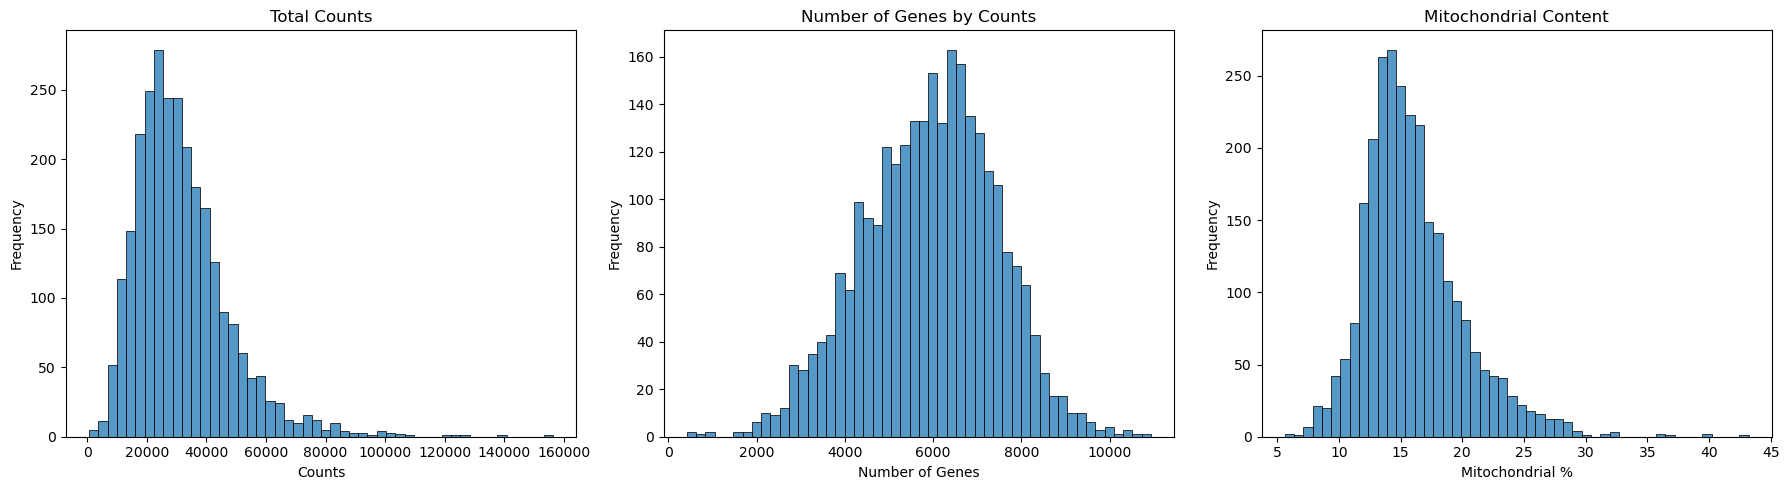

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for recalculated QC metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Total counts
sns.histplot(adata.obs["total_counts"], kde=False, bins=50, ax=axs[0])
axs[0].set_title("Total Counts")
axs[0].set_xlabel("Counts")
axs[0].set_ylabel("Frequency")

# Number of genes by counts
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=50, ax=axs[1])
axs[1].set_title("Number of Genes by Counts")
axs[1].set_xlabel("Number of Genes")
axs[1].set_ylabel("Frequency")

# Mitochondrial content
sns.histplot(adata.obs["pct_counts_mt"], kde=False, bins=50, ax=axs[2])
axs[2].set_title("Mitochondrial Content")
axs[2].set_xlabel("Mitochondrial %")
axs[2].set_ylabel("Frequency")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

This is an overview of what is happening to our dataset let's focus on each metric below.

## 2.1.3 Library size threshold plot

We can plot a histogram of the library sizes across spots. The library size is the number of UMI counts in each spot.

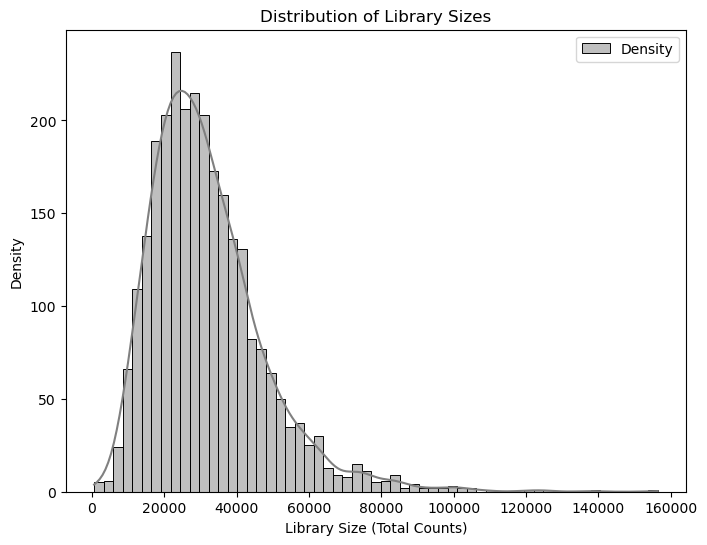

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram and density of library sizes
plt.figure(figsize=(8, 6))
sns.histplot(adata.obs['total_counts'], kde=True, color='gray', label='Density')
# plt.axvline(x=700, color='red', linestyle='--', label='Threshold (700)')
plt.title('Distribution of Library Sizes')
plt.xlabel('Library Size (Total Counts)')
plt.ylabel('Density')
plt.legend()
plt.show()

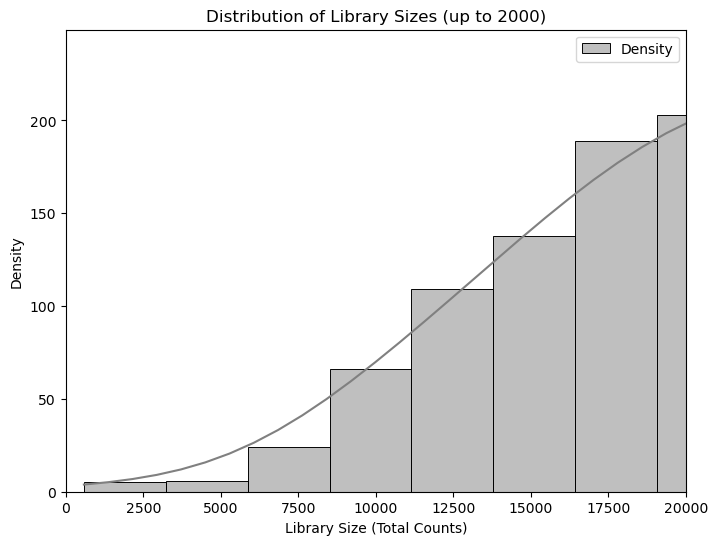

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram and density of library sizes
plt.figure(figsize=(8, 6))
sns.histplot(adata.obs['total_counts'], kde=True, color='gray', label='Density')
# Set x-axis limit to 2000
plt.xlim(0, 20000)
# Optional: Add a threshold line if needed
# plt.axvline(x=700, color='red', linestyle='--', label='Threshold (700)')
plt.title('Distribution of Library Sizes (up to 2000)')
plt.xlabel('Library Size (Total Counts)')
plt.ylabel('Density')
plt.legend()
plt.show()

Scatter Plot of Library Size vs. Cell Count

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Library size threshold plot</span>  
<ul>
    <li>What is density in the yy axis?</li>

</div>

To get a glimpse of how library size changes spatially:

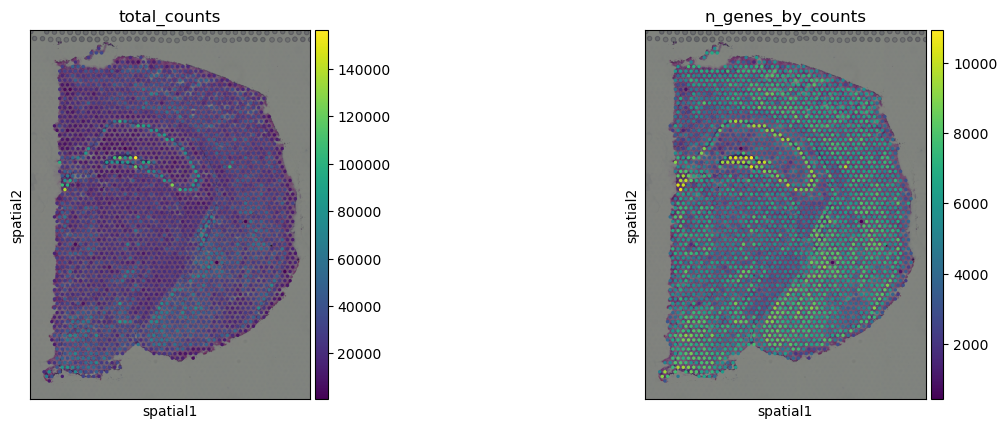

In [20]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [21]:
# Apply a threshold for low library size (e.g., 10000 UMI counts)
adata.obs['qc_lib_size'] = adata.obs['total_counts'] < 10000

# Count the number of spots flagged as low library size
low_library_count = adata.obs['qc_lib_size'].sum()
print(f"Number of spots with low library size: {low_library_count}")

Number of spots with low library size: 68


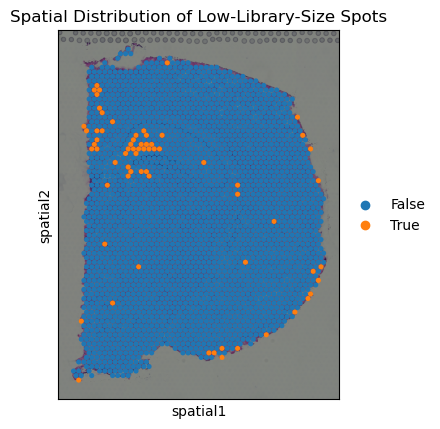

In [22]:
import scanpy as sc

# Visualize spots flagged for low library size
sc.pl.spatial(
    adata,
    color='qc_lib_size',
    size=1.5,
    title="Spatial Distribution of Low-Library-Size Spots"
)

Number of spots flagged with stricter threshold (2000): 615


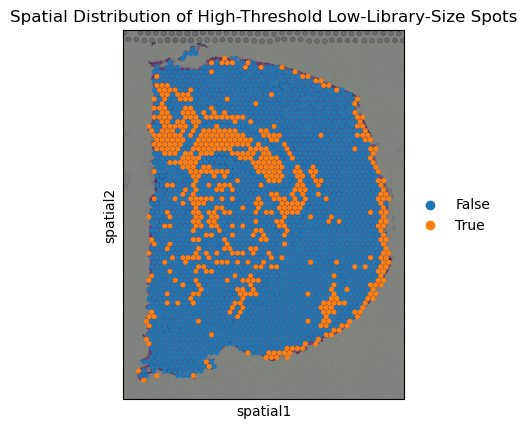

In [23]:
# Apply a stricter threshold for library size
adata.obs['qc_lib_size_high'] = adata.obs['total_counts'] < 20000

# Count the number of spots flagged with the stricter threshold
high_threshold_count = adata.obs['qc_lib_size_high'].sum()
print(f"Number of spots flagged with stricter threshold (2000): {high_threshold_count}")

# Visualize spots flagged with stricter threshold
sc.pl.spatial(
    adata,
    color='qc_lib_size_high',
    size=1.5,
    title="Spatial Distribution of High-Threshold Low-Library-Size Spots"
)

We need to keep in mind here that the threshold is, to an extent, arbitrary. It is therefore important to look at the number of spots that are left out of the dataset by this choice of cut-off value, and also have a look at their putative spatial patterns. If we filtered out spots with biological relevance, then we should observe some patterns on the tissue map that correlate with some of the known biological structures of the tissue. If we do observe such a phenomenon, we have probably set our threshold too high (i.e. not permissive enough).

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Library size threshold plot</span>  
<ul>
    <li>Do you see any spatial patterning while we are thresholding?</li>

</div>

Number of spots flagged with stricter threshold (2000): 16


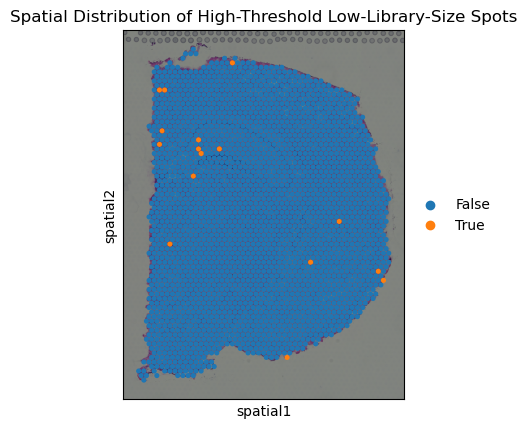

In [24]:
# Apply a stricter threshold for library size
adata.obs['qc_lib_size_high'] = adata.obs['total_counts'] < 7000

# Count the number of spots flagged with the stricter threshold
high_threshold_count = adata.obs['qc_lib_size_high'].sum()
print(f"Number of spots flagged with stricter threshold (2000): {high_threshold_count}")

# Visualize spots flagged with stricter threshold
sc.pl.spatial(
    adata,
    color='qc_lib_size_high',
    size=1.5,
    title="Spatial Distribution of High-Threshold Low-Library-Size Spots"
)

## 2.1.4 Number of expressed genes

As we did with the library sizes, we can plot a histogram of the number of expressed genes across spots. A gene is “expressed” in a spot if it has at least one count in it.

/tmp/ipykernel_129213/1510646086.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


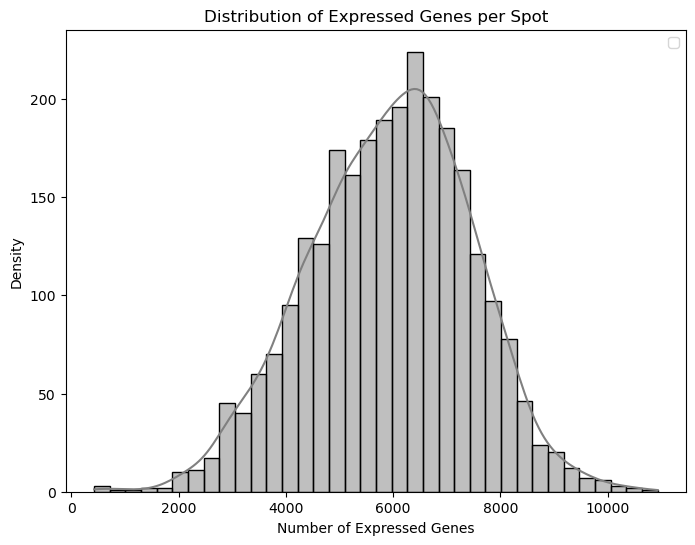

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of expressed genes
plt.figure(figsize=(8, 6))
sns.histplot(adata.obs['n_genes_by_counts'], kde=True, color='gray')
plt.title('Distribution of Expressed Genes per Spot')
plt.xlabel('Number of Expressed Genes')
plt.ylabel('Density')
# plt.axvline(x=2000, color='red', linestyle='--', label='Threshold (500)')
plt.legend()
plt.show()

Finally, again as before, we apply the chosen threshold to flag spots with (in this case) fewer than 500 expressed genes.

In [26]:
# Apply the threshold for the number of expressed genes
threshold_expressed_genes = 2000
adata.obs['qc_expressed_genes'] = adata.obs['n_genes_by_counts'] < threshold_expressed_genes

# Count the number of spots flagged as low-quality based on expressed genes
low_quality_genes_count = adata.obs['qc_expressed_genes'].sum()
print(f"Number of spots with fewer than {threshold_expressed_genes} expressed genes: {low_quality_genes_count}")

Number of spots with fewer than 2000 expressed genes: 10


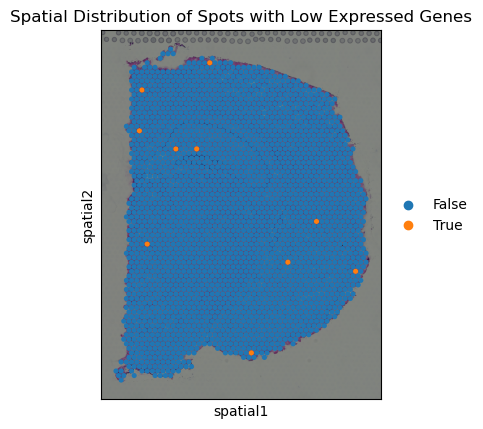

In [27]:
# Visualize spots flagged for low expressed genes
sc.pl.spatial(
    adata,
    color='qc_expressed_genes',
    size=1.5,
    title='Spatial Distribution of Spots with Low Expressed Genes'
)

Optional: Adjust Threshold to Test Over-Enthusiastic Filtering

Number of spots flagged with stricter threshold (4000): 292


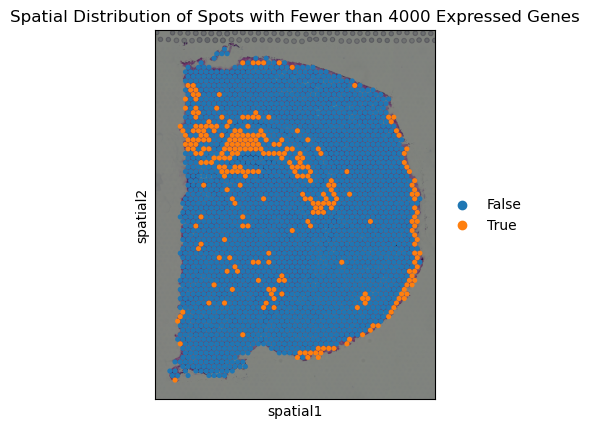

In [28]:
# Apply a stricter threshold for expressed genes
strict_threshold_expressed_genes = 4000
adata.obs['qc_expressed_genes_strict'] = adata.obs['n_genes_by_counts'] < strict_threshold_expressed_genes

# Count the number of spots flagged with the stricter threshold
strict_flagged_count = adata.obs['qc_expressed_genes_strict'].sum()
print(f"Number of spots flagged with stricter threshold ({strict_threshold_expressed_genes}): {strict_flagged_count}")

# Visualize spatial distribution of strictly flagged spots
sc.pl.spatial(
    adata,
    color='qc_expressed_genes_strict',
    size=1.5,
    title=f'Spatial Distribution of Spots with Fewer than {strict_threshold_expressed_genes} Expressed Genes'
)

## 2.1.5 Percentage of mitochondrial expression

As we briefly touched on at the beginning, a high proportion of mitochondrial reads indicates low cell quality, probably due to cell damage.

We calculated this data earlier on in this session, and can now investigate the percentage of mitochondrial expression across spots

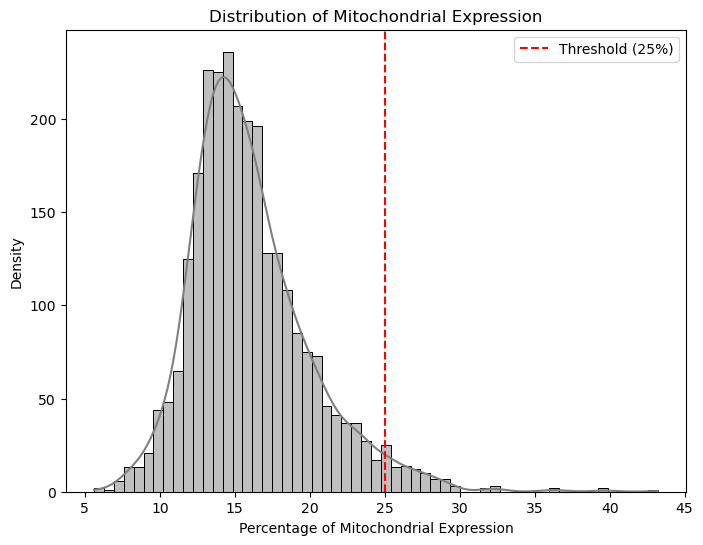

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of mitochondrial expression
if 'pct_counts_mt' in adata.obs.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(adata.obs['pct_counts_mt'], kde=True, color='gray')
    plt.title('Distribution of Mitochondrial Expression')
    plt.xlabel('Percentage of Mitochondrial Expression')
    plt.ylabel('Density')
    plt.axvline(x=25, color='red', linestyle='--', label='Threshold (25%)')
    plt.legend()
    plt.show()
else:
    print("The 'pct_counts_mt' column does not exist in adata.obs. Skipping the histogram plot.")

In this instance, a higher percentage of mitochondrial expression is the thing to avoid, so the threshold is an upper bound, rather than the lower bounds we have observed so far. Our suggestion this time is to cut-off at 28%.

In [30]:
# Apply the threshold for mitochondrial expression
threshold_mito_percent = 25
if 'pct_counts_mt' in adata.obs.columns:
    adata.obs['qc_mito'] = adata.obs['pct_counts_mt'] > threshold_mito_percent

    # Count the number of flagged spots
    flagged_mito_count = adata.obs['qc_mito'].sum()
    print(f"Number of spots with mitochondrial expression above {threshold_mito_percent}%: {flagged_mito_count}")
else:
    print("The 'pct_counts_mt' column does not exist in adata.obs. Skipping thresholding.")

Number of spots with mitochondrial expression above 25%: 91


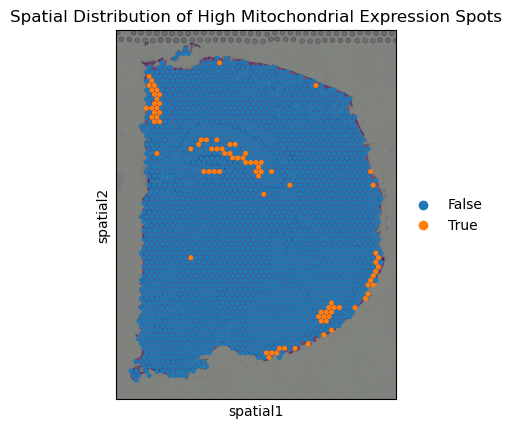

In [31]:
# Visualize spatial distribution of flagged spots based on mitochondrial expression
if 'qc_mito' in adata.obs.columns:
    import scanpy as sc
    sc.pl.spatial(
        adata,
        color='qc_mito',
        size=1.5,
        title='Spatial Distribution of High Mitochondrial Expression Spots'
    )
else:
    print("The 'qc_mito' column does not exist in adata.obs. Skipping spatial visualization.")

Again, try to illustrate what happens if we set the threshold too low (i.e., 20 0r 25%).

## 2.1.6 Remove low-quality spots

All the steps so far have flagged spots with potential issues - before proceeding with the analysis; we want to remove these spots from our adata object. Since we have calculated different spot-level QC metrics and selected thresholds for each one, we can combine them to identify a set of low-quality spots, and remove them from our spe object in a single step.

Number of discarded spots for each metric:
{'qc_lib_size': 68, 'qc_expressed_genes': 10, 'qc_mito': 91}
Total spots marked as discarded: 139


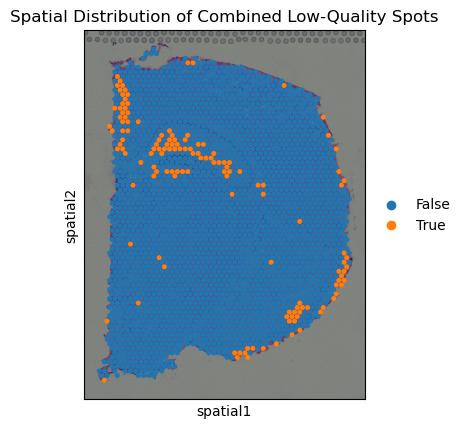

No 'ground_truth' column found in adata.obs. Skipping NA spot filtering.


In [32]:
# Step 1: Check the number of discarded spots for each metric
metrics_to_check = ['qc_lib_size', 'qc_expressed_genes', 'qc_mito']
discarded_counts = {}
for metric in metrics_to_check:
    if metric in adata.obs.columns:
        discarded_counts[metric] = adata.obs[metric].sum()
    else:
        print(f"Warning: '{metric}' column not found in adata.obs.")

print("Number of discarded spots for each metric:")
print(discarded_counts)

# Step 2: Combine the set of discarded spots
if all(metric in adata.obs.columns for metric in metrics_to_check):
    adata.obs['discard'] = (
        adata.obs['qc_lib_size'] |
        adata.obs['qc_expressed_genes'] |
        adata.obs['qc_mito']
    )
    print(f"Total spots marked as discarded: {adata.obs['discard'].sum()}")
else:
    print("Error: One or more required QC metrics are missing. Cannot combine discarded spots.")

# Step 3: Visualize the spatial pattern of combined discarded spots
if 'discard' in adata.obs.columns:
    import scanpy as sc
    sc.pl.spatial(
        adata,
        color='discard',
        size=1.5,
        title='Spatial Distribution of Combined Low-Quality Spots'
    )
else:
    print("Error: 'discard' column not found in adata.obs. Cannot visualize.")

# Step 4: Further remove spots with missing annotations (optional)
if 'ground_truth' in adata.obs.columns:
    # Create a QC column for spots without annotations
    adata.obs['qc_NA_spots'] = adata.obs['ground_truth'].isna()
    # Update the combined discard column
    adata.obs['discard'] = (
        adata.obs['discard'] |
        adata.obs['qc_NA_spots']
    )
    print(f"Number of spots without annotation: {adata.obs['qc_NA_spots'].sum()}")
    print(f"Total spots marked as discarded (after including NA spots): {adata.obs['discard'].sum()}")

    # Visualize the updated spatial pattern
    sc.pl.spatial(
        adata,
        color='discard',
        size=1.5,
        title='Spatial Distribution of Discarded Spots (Including NA Annotations)'
    )
else:
    print("No 'ground_truth' column found in adata.obs. Skipping NA spot filtering.")

In [33]:
adata

AnnData object with n_obs × n_vars = 2702 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'qc_lib_size', 'qc_lib_size_high', 'qc_expressed_genes', 'qc_expressed_genes_strict', 'qc_mito', 'discard'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'qc_lib_size_colors', 'qc_lib_size_high_colors', 'qc_expressed_genes_colors', 'qc_expressed_genes_strict_colors', 'qc_mito_colors', 'discard_colors'
    obsm: 'spatial'

In [34]:
sc.pp.filter_cells(adata, min_counts=7000)
sc.pp.filter_cells(adata, max_counts=80000)
adata

filtered out 16 cells that have less than 7000 counts
filtered out 40 cells that have more than 80000 counts


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2646 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'qc_lib_size', 'qc_lib_size_high', 'qc_expressed_genes', 'qc_expressed_genes_strict', 'qc_mito', 'discard', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'qc_lib_size_colors', 'qc_lib_size_high_colors', 'qc_expressed_genes_colors', 'qc_expressed_genes_strict_colors', 'qc_mito_colors', 'discard_colors'
    obsm: 'spatial'

In [35]:
adata = adata[adata.obs["pct_counts_mt"] < 25].copy()
print(f"#cells after MT filter: {adata.n_obs}")

#cells after MT filter: 2559


In [36]:
sc.pp.filter_genes(adata, min_cells=10)
adata

filtered out 14853 genes that are detected in less than 10 cells


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2559 × 17432
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'qc_lib_size', 'qc_lib_size_high', 'qc_expressed_genes', 'qc_expressed_genes_strict', 'qc_mito', 'discard', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'qc_lib_size_colors', 'qc_lib_size_high_colors', 'qc_expressed_genes_colors', 'qc_expressed_genes_strict_colors', 'qc_mito_colors', 'discard_colors'
    obsm: 'spatial'

In [37]:
# Apply the threshold for the number of expressed genes
threshold_expressed_genes = 2000
adata.obs['qc_expressed_genes'] = adata.obs['n_genes_by_counts'] >= threshold_expressed_genes

# Count the number of spots flagged as high-quality based on expressed genes
high_quality_genes_count = adata.obs['qc_expressed_genes'].sum()
print(f"Number of spots with at least {threshold_expressed_genes} expressed genes: {high_quality_genes_count}")

# Filter the dataset to keep only high-quality spots
adata = adata[adata.obs['qc_expressed_genes'], :]

# Print the shape of the filtered dataset
print(f"Number of spots retained after filtering: {adata.shape[0]}")
adata

Number of spots with at least 2000 expressed genes: 2559
Number of spots retained after filtering: 2559


View of AnnData object with n_obs × n_vars = 2559 × 17432
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'qc_lib_size', 'qc_lib_size_high', 'qc_expressed_genes', 'qc_expressed_genes_strict', 'qc_mito', 'discard', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'qc_lib_size_colors', 'qc_lib_size_high_colors', 'qc_expressed_genes_colors', 'qc_expressed_genes_strict_colors', 'qc_mito_colors', 'discard_colors'
    obsm: 'spatial'

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Library size threshold plot</span>  
<ul>
    <li> What about plotting after QC thresholding?</li>

</div>

# 2.2 Normalisation of counts

# *Normalization in Spatial Transcriptomics (STx)*

Normalization is essential in Spatial Transcriptomics (STx) to account for systematic effects in count data, such as variations in library size (counts/UMIs per spot), which are not biologically meaningful. Proper normalization ensures accurate comparisons of expression levels and reliable downstream analyses.

---

## *Library Size Scaling*
- **Objective:** Adjust library sizes across all spots so that their mean becomes 1.
- **Method:** 
  - Counts are scaled using library size factors.
  - This adjustment corrects for differences in sequencing depth or total counts.
- **Outcome:** Enables more accurate comparisons of expression levels between spots.

---

## *Log-Transformation*
- **Purpose:** Stabilizes variance and prevents dominance by highly expressed genes.
- **Methodology:**
  - A log-transformation is applied after adding a pseudocount of 1 to avoid undefined values for `log2(0)`.
  - Helps render expression changes symmetrical for easier comparisons.
- **Benefit:** Facilitates downstream analyses by reducing biases caused by extreme values.

---

## *STx vs. scRNA-seq Normalization*
Normalization in STx differs from scRNA-seq due to the following challenges:
- **Spots Containing Multiple Cell Types:**
  - Unlike single-cell data, STx spots often represent a mixture of cell types, making cell-level normalization less effective.
- **Clustering Variability:**
  - Datasets often span multiple tissue samples, introducing variability in clustering and expression patterns.
- **Importance in STx:**
  - Proper normalization is foundational for reliable downstream analyses, as it ensures systematic biases are minimized.

---


In [38]:
# Ensure raw counts are used
adata.raw = adata.raw if adata.raw else adata.copy()

# Define normalization methods
normalization_methods = {
    "Raw Counts": adata.raw.to_adata(),
    "Normalize Total (default)": adata.raw.to_adata(),
    "Exclude Highly Expressed": adata.raw.to_adata(),
    "SCTransform": adata.raw.to_adata(),
    "Log-Normalization": adata.raw.to_adata(),
    "Quantile Normalization": adata.raw.to_adata(),
}

# Apply normalization methods
# 1. Raw Counts: No change

# 2. Normalize Total
sc.pp.normalize_total(normalization_methods["Normalize Total (default)"], target_sum=1e6)

# 3. Exclude Highly Expressed
sc.pp.normalize_total(
    normalization_methods["Exclude Highly Expressed"], target_sum=1e6, exclude_highly_expressed=True
)

# 4. SCTransform (handle NaN or invalid values)
try:
    sc.experimental.pp.normalize_pearson_residuals(normalization_methods["SCTransform"])
except RuntimeWarning:
    sc.pp.filter_genes(normalization_methods["SCTransform"], min_counts=1)  # Filter out zero-count genes
    sc.experimental.pp.normalize_pearson_residuals(normalization_methods["SCTransform"])

# 5. Log-Normalization
sc.pp.log1p(normalization_methods["Log-Normalization"])

# 6. Quantile Normalization (convert sparse to dense)
adata_qnorm = normalization_methods["Quantile Normalization"]
adata_qnorm.X = pd.DataFrame(adata_qnorm.X.toarray()).rank(method="average", axis=0).to_numpy()


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Ptgds', 'Hbb-bs', 'Bc1', 'Pmch', 'Hba-a1', 'Gm42418', 'Ttr', 'Plp1']
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:01)


<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Library size threshold plot</span>  
<ul>
    <li>Can you check in Enrichr how relevant these genes are https://maayanlab.cloud/Enrichr/?</li>

</div>

# 2.3 Selecting genes

### 2.3.1 Background

Gene selection - or alternatively “feature selection” - is applied to identify genes that are likely to be informative for downstream analyses. The most common feature selection method is the definition of highly variable genes (HVGs). The assumption is that since we quality-controlled and normalised our dataset, the genes with high variability are the ones that contain high levels of biological variability too. Since here we have a spatial dataset we can also try to identify spatially variable genes too (SVGs).

It is important to note that HVGs are identified solely from the gene expression data. Spatial information does not play a role in finding HVGs. STx data pose a dilemma; does the meaningful spatial information reflect only spatial distribution of major cell types or does it reflect additional important spatial features? If we believe the former, relying on HVGs can be enough. If the second also holds true though, it is important to identify SVGs as well.

### 2.3.2 Highly Variable Genes (HVGs)

Right now, let's check how HVG are affected by the previous normalisation strategies:

Skipping Raw Counts due to data issues or unsuitability for HVG detection.
Processing Normalize Total (default):
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of Highly Variable Genes for Normalize Total (default): 1743


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Top 20 Highly Variable Genes for Normalize Total (default):
['Oxt', 'Ttr', 'Hcrt', 'Igkc', 'Avp', 'Pmch', 'Igha', 'Agrp', 'Hbb-bs', 'Ptgds', 'Cga', 'Plp1', 'Bc1', 'Hba-a1', 'Mbp', 'Gal', 'Cartpt', 'Ecrg4', 'Hba-a2', 'Npy']


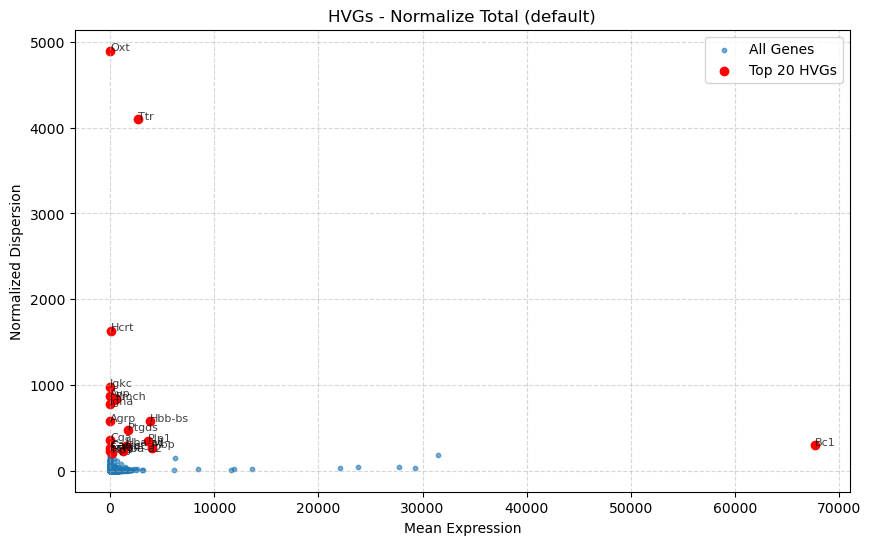

Top 20 HVGs for Normalize Total (default) (printed as a list):
1. Oxt
2. Ttr
3. Hcrt
4. Igkc
5. Avp
6. Pmch
7. Igha
8. Agrp
9. Hbb-bs
10. Ptgds
11. Cga
12. Plp1
13. Bc1
14. Hba-a1
15. Mbp
16. Gal
17. Cartpt
18. Ecrg4
19. Hba-a2
20. Npy
--------------------------------------------------
Processing Exclude Highly Expressed:
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of Highly Variable Genes for Exclude Highly Expressed: 1743


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Top 20 Highly Variable Genes for Exclude Highly Expressed:
['Ttr', 'Oxt', 'Hcrt', 'Igkc', 'Pmch', 'Avp', 'Igha', 'Hbb-bs', 'Ptgds', 'Agrp', 'Bc1', 'Plp1', 'Hba-a1', 'Cga', 'Mbp', 'Ecrg4', 'Cartpt', 'Hba-a2', 'Gal', 'Gm42418']


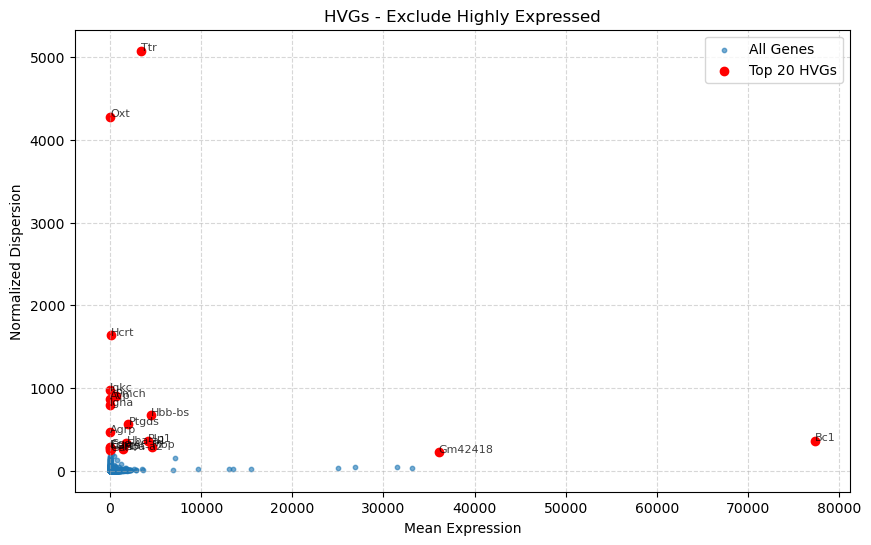

Top 20 HVGs for Exclude Highly Expressed (printed as a list):
1. Ttr
2. Oxt
3. Hcrt
4. Igkc
5. Pmch
6. Avp
7. Igha
8. Hbb-bs
9. Ptgds
10. Agrp
11. Bc1
12. Plp1
13. Hba-a1
14. Cga
15. Mbp
16. Ecrg4
17. Cartpt
18. Hba-a2
19. Gal
20. Gm42418
--------------------------------------------------
Processing SCTransform:
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of Highly Variable Genes for SCTransform: 558
Top 20 Highly Variable Genes for SCTransform:
['4930523C07Rik', 'Zfp449', 'Lrrtm2', 'Pms1', 'Pvalb', 'Pcp4', 'Fgf22', 'Tagln', 'Sdcbp2', 'Cplx3', 'Sparc', 'Ctbs', 'Atp2b1', 'Smarcad1', 'Dbi', 'Ttc39d', 'Cplx2', 'Cplx1', 'Cps1', 'Rgs4']


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


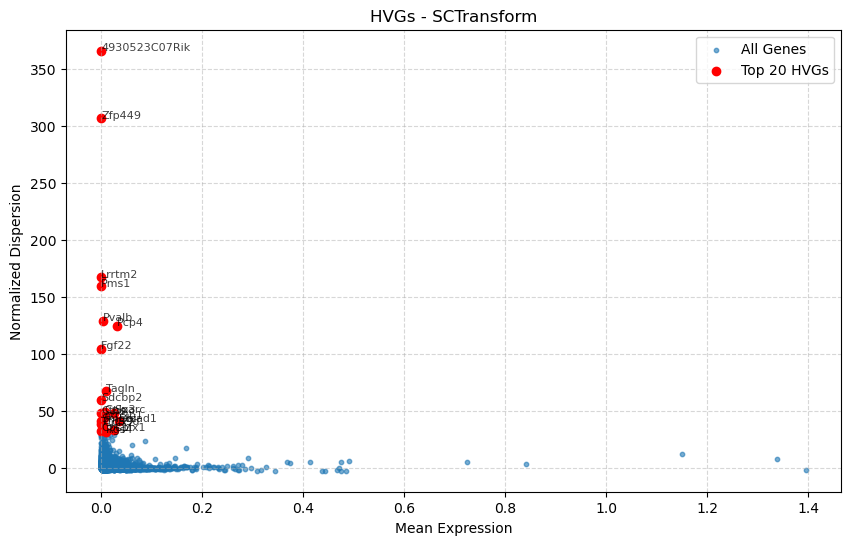

Top 20 HVGs for SCTransform (printed as a list):
1. 4930523C07Rik
2. Zfp449
3. Lrrtm2
4. Pms1
5. Pvalb
6. Pcp4
7. Fgf22
8. Tagln
9. Sdcbp2
10. Cplx3
11. Sparc
12. Ctbs
13. Atp2b1
14. Smarcad1
15. Dbi
16. Ttc39d
17. Cplx2
18. Cplx1
19. Cps1
20. Rgs4
--------------------------------------------------
Processing Log-Normalization:
extracting highly variable genes
    finished (0:00:00)


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of Highly Variable Genes for Log-Normalization: 1744
Top 20 Highly Variable Genes for Log-Normalization:
['Igha', 'Cyp2f2', 'Qrfp', 'Cma1', 'H2-Q1', 'Tshb', 'Tyrp1', 'Mup6', 'Lypd2', 'Cxcl10', 'Ngp', 'Olfr570', 'Gm15478', 'Camp', 'Gm38534', 'Dnah12', 'Agrp', 'Cga', 'Gm39653', 'Gal']


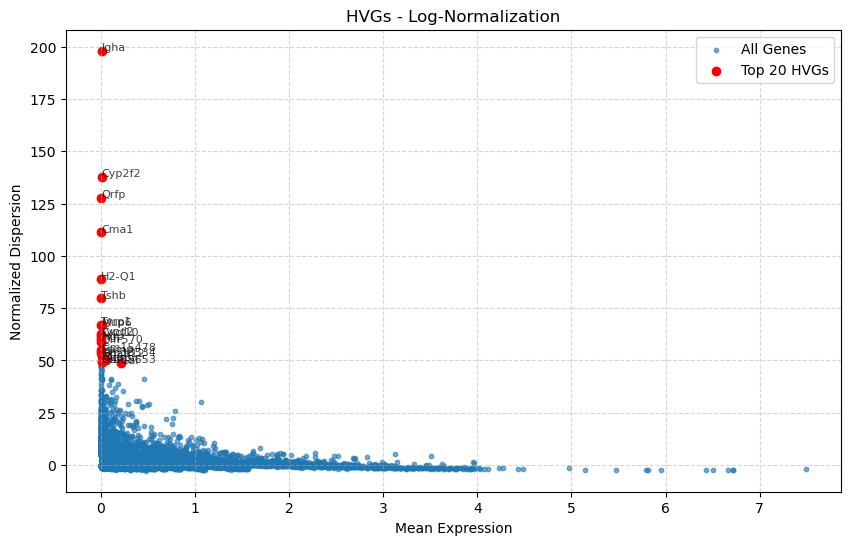

Top 20 HVGs for Log-Normalization (printed as a list):
1. Igha
2. Cyp2f2
3. Qrfp
4. Cma1
5. H2-Q1
6. Tshb
7. Tyrp1
8. Mup6
9. Lypd2
10. Cxcl10
11. Ngp
12. Olfr570
13. Gm15478
14. Camp
15. Gm38534
16. Dnah12
17. Agrp
18. Cga
19. Gm39653
20. Gal
--------------------------------------------------
Skipping Quantile Normalization due to data issues or unsuitability for HVG detection.


In [41]:
for method, norm_adata in normalization_methods.items():
    if method in ["Raw Counts", "Quantile Normalization"]:  # Skip Raw Counts and Quantile Normalization
        print(f"Skipping {method} due to data issues or unsuitability for HVG detection.")
        continue

    print(f"Processing {method}:")

    # Step 1: Filter out genes with near-zero mean expression
    if issparse(norm_adata.X):  # Handle sparse matrices
        gene_filter = norm_adata.X.mean(axis=0).A1 > 1e-12
    else:  # Dense matrices
        gene_filter = norm_adata.X.mean(axis=0) > 1e-12
    norm_adata = norm_adata[:, gene_filter]  # Filter genes

    # Step 2: Identify highly variable genes
    sc.pp.highly_variable_genes(
        norm_adata,
        flavor="cell_ranger",  # Use cell_ranger flavor for robust HVG detection
        n_top_genes=int(0.1 * norm_adata.shape[1]),  # Top 10% HVGs
        subset=False  # Do not subset the data yet
    )

    # Step 3: Display the number of HVGs
    hvg_count = norm_adata.var["highly_variable"].sum()
    print(f"Number of Highly Variable Genes for {method}: {hvg_count}")

    # Step 4: Get the top 20 HVGs by dispersion
    top_20_hvgs = norm_adata.var[norm_adata.var["highly_variable"]].sort_values(
        by="dispersions_norm", ascending=False
    ).head(20)
    print(f"Top 20 Highly Variable Genes for {method}:")
    print(top_20_hvgs.index.tolist())

    # Step 5: Plot HVGs manually
    plt.figure(figsize=(10, 6))
    plt.scatter(
        norm_adata.var["means"], norm_adata.var["dispersions_norm"], alpha=0.6, s=10, label="All Genes"
    )
    plt.scatter(
        top_20_hvgs["means"], top_20_hvgs["dispersions_norm"], color="red", label="Top 20 HVGs"
    )

    # Annotate the top 20 HVGs
    for gene in top_20_hvgs.index:
        mean = top_20_hvgs.loc[gene, "means"]
        disp = top_20_hvgs.loc[gene, "dispersions_norm"]
        plt.text(mean, disp, gene, fontsize=8, alpha=0.75)

    plt.xlabel("Mean Expression")
    plt.ylabel("Normalized Dispersion")
    plt.title(f"HVGs - {method}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Step 6: Print top 20 genes for clarity
    print(f"Top 20 HVGs for {method} (printed as a list):")
    for i, gene in enumerate(top_20_hvgs.index.tolist(), start=1):
        print(f"{i}. {gene}")
    print("-" * 50)

In [ ]:
<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">HVG and biological on-the-fly evaluation</span>  
<ul>
    <li>Which of these gene-sets appear more biological plausible based on prior knowledge (e.g., https://maayanlab.cloud/Enrichr/)?</li>

</div>

# 2.4 Dimensionality reduction and clustering

Now we can check how the different normalisation strategies are affecting dimensionality reduction and clustering:

In [ ]:
# Initialize the results dictionary
umap_results = {}

for method, norm_adata in normalization_methods.items():
    print(f"Processing normalization method: {method}")
    
    # Step 1: Compute PCA
    sc.tl.pca(norm_adata)  # Ensure at least 10 PCs for neighbors calculation
    norm_adata.obsm['X_pca'] = norm_adata.obsm['X_pca'][:, :2]  # Keep the first two PCs for visualization
    
    # Step 2: Compute neighbors
    sc.pp.neighbors(norm_adata, n_neighbors=15)  # Adjust `n_neighbors` and `n_pcs` as needed
    
    # Step 3: Compute clustering (Leiden)
    sc.tl.leiden(norm_adata, resolution=0.2)  # Adjust resolution for desired granularity
    
    # Step 4: Compute UMAP
    sc.tl.umap(norm_adata)
    
    # Step 5: Store PCA, UMAP results, and clusters
    umap_results[method] = {
        'pca': norm_adata.obsm['X_pca'],
        'umap': norm_adata.obsm['X_umap'],
        'clusters': norm_adata.obs['leiden']
    }
    
    # Step 6: Plot PCA
    plt.figure(figsize=(6, 6))
    plt.scatter(norm_adata.obsm['X_pca'][:, 0], norm_adata.obsm['X_pca'][:, 1],
                c=norm_adata.obs['leiden'].astype(int), cmap='tab20', s=10, alpha=0.8)
    plt.title(f"PCA Clustering ({method})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label="Cluster")
    plt.show()
    
    # Step 7: Plot UMAP
    sc.pl.umap(
        norm_adata,
        color="leiden",
        title=f"UMAP Clustering ({method})",
        show=False,
        legend_loc='on data'
    )
    plt.show()
    
    # Step 8: Plot spatial clustering if spatial data is available
    if "spatial" in norm_adata.uns:
        sc.pl.spatial(
            norm_adata,
            img_key="hires",
            color="leiden",
            size=1.5,
            title=f"Spatial Clustering ({method})"
        )
    
    norm_adata.var_names_make_unique()
    
    # Step 9: Identify cluster-specific marker genes
    sc.tl.rank_genes_groups(norm_adata, groupby="leiden", method="t-test")  # Adjust method if needed
    
    # Step 10: Plot a heatmap for a specific cluster
    #cluster_to_plot = "9"  # Specify the cluster of interest
    print(f"Plotting heatmap for cluster {cluster_to_plot} ({method})...")
    sc.pl.rank_genes_groups_heatmap(
        norm_adata,
        #groups=cluster_to_plot,
        n_genes=10,  # Number of top genes to display
        groupby="leiden",
        show=False
    )
    plt.title(f"Top Marker Genes for Cluster {cluster_to_plot} ({method})")
    plt.show()

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Normalisation and downstream processing</span>  
<ul>
    <li>With which normalisation strategy do you see more plausible clusterings based on the ground-truth image?</li>

</div>

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Normalisation and downstream processing</span>  
<ul>
    <li>Re-run the pipeline with different QC; more conservative or more extreme, what do you see?</li>

</div>

# 2.5 SpatialData and Visium_HD

In [6]:
sdata_visium_hd = visium_hd("/data/spatial_workshop/day1/practical_0/visium_hd_3.0.0_io_subset", filtered_counts_file=False)

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_132888/134567724.py:1: UserWarning: No full resolution image found. If incorrect, please specify the path in the `fullres_image_file` parameter when calling the `visium_hd` reader function.
  sdata_visium_hd = visium_hd("/data/spatial_workshop/day1/practical_0/visium_hd_3.0.0_io_subset", filtered_counts_fi

In [ ]:
# sdata_visium_hd.tables["square_008um"].var_names_make_unique()  # modifies in-place

In [ ]:
# for table in sdata.tables.values():
#     table.var_names_make_unique()

We will use the .query.bounding_box() function to subset the data so that we can visually inspect the result easier. This function allows us to subset the data to a specific bounding box, which is defined by the top-left and bottom-right coordinates. This is useful when working with large datasets, as it allows us to only load the data that we're interested in.

In [ ]:
# sdata_visium_hd_crop.tables["square_008um"].to_df().apply(
#     lambda col: col.var(), axis=0
# ).sort_values()

In [ ]:
# sdata_visium_hd_crop.pl.render_shapes(color="Igha", method="matplotlib").pl.show(
#     "downscaled_hires", figsize=(10, 10)
# )

We can see that these bins are continous, so when overlaying the expression over an image, we would no longer see the image. To counter this, we will modify the colormap we'll use so that true 0s in the expression matrix are shown fully transparent. The spatialdata-plot library provides a helper function for this.

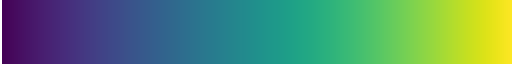

In [50]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

cmap = set_zero_in_cmap_to_transparent(plt.cm.viridis)
cmap

We can now use this cmap to visualise the spatial expression of the genes. We see that the gene is only expressed in certain areas of the slide.

In [ ]:
sdata_visium_hd_crop.pl.render_images().pl.render_shapes(
    color="Igha", method="matplotlib", cmap=cmap
).pl.show("downscaled_hires", figsize=(8, 6))

In [53]:
# Import necessary libraries
import spatialdata as sd
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
import matplotlib.pyplot as plt

In [49]:
# Define a function to crop a specific region
def crop_region(sdata, min_coord, max_coord):
    return sdata.query.bounding_box(
        axes=["x", "y"],
        min_coordinate=min_coord,
        max_coordinate=max_coord,
        target_coordinate_system="global",
    )

Let’s now pre-compute a lazy-rasterized version of the data using `rasterize_bins()`. This operation takes just a few seconds and unlocks very fast on-demand channel-wise rasterization.

In [ ]:
%%time
from spatialdata import rasterize_bins

for bin_size in ["016", "008", "002"]:
    # rasterize_bins() requires a compresed sparse column (csc) matrix
    sdata_visium_hd.tables[f"square_{bin_size}um"].X = sdata_visium_hd.tables[f"square_{bin_size}um"].X.tocsc()
    rasterized = rasterize_bins(
        sdata_visium_hd,
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size}um",
        f"square_{bin_size}um",
        "array_col",
        "array_row",
    )
    sdata_visium_hd[f"rasterized_{bin_size}um"] = rasterized

This produces lazy image objects that can be accessed gene-wise exceptionally efficiently.

Importantly, these objects should not be computed as a whole, because this would lead to the unnecessary computation of hundreds of GB of memory.

In [ ]:
%%time
# this is very fast
sdata_visium_hd["rasterized_002um"].sel(c=gene_name).compute()
# this must not be called
# sdata["rasterized_002um"].compute()

Here is an example of how to plot the rasterized data. Please pay attention to setting scale="full"; this is essential. If it is not set, spatialdata-plot will try to re-rasterize the data to fit the canvas size and try to compute the whole object.

In [ ]:
%%time
plt.figure(figsize=(10, 10))
ax = plt.gca()

sdata_visium_hd.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(coordinate_systems="global", ax=ax)

As you can see below, we can plot the 2µm bins very performantly, which would not be possible with the matplotlib based approach shown before.

Note: when we plot the full data below the plot appears as uniformly violet. This happens because the data is very sparse and the bins are too small for the target figure size; since most of the non-zero bins are 1s the final interpolated colors are very close to the zero value and difficult to see.

Let’s therefore:

change the limits of the plot to show a portion of the data to avoid interpolation artifacts

plot a binary mask of the full data to avoid the interpolated data to be to close to 0.

In [ ]:
from matplotlib.colors import ListedColormap

# define the colors for the colormap (black for zeros, white for > 0)
colors = ["#000000", "#ffffff"]  # Black, White
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 10))

# bug: interpolation artifact, everything is black with a few sporadic white points: https://github.com/scverse/spatialdata-plot/issues/351
# ax = plt.gca()
# let's set a small vmax value so that the color is white also after interpolation
# sdata.pl.render_images("rasterized_002um", channel=gene_name, scale="full", vmin=0, vmax=0.01, cmap=cmap).pl.show(
# coordinate_systems="global", ax=ax
# )

# workaround
plt.imshow(sdata_visium_hd["rasterized_002um"].sel(c=gene_name).data.compute(), cmap=cmap, vmin=0, vmax=0.01)
plt.colorbar()

plt.show()

As a final not on the on-the-fly rasterization approach. Please, by looking at the corners of the last plot, notice how the data is on a grid that is actually sligthly rotated. The advantage of using rasterize_bins() is that the produced object contains the coordinate transformations necessary to align (rotation and scale) the rasterized data together with the high-resolution images.

In [ ]:
sdata_small = sdata_visium_hd.query.bounding_box(
    min_coordinate=[7000, 11000], max_coordinate=[10000, 14000], axes=("x", "y"), target_coordinate_system="global"
)

In [ ]:
gene_name = "AA986860"
sdata_small.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="global"
)

Notice how a Moiré pattern is visible. This is due to the fact that the grid is not axis-aligned but presents a small rotation. A solution is to switch to datashader as a backend (which is enabled by default when the number of geometries is large). This will create some artifacts (bins of different sizes, some “holes” in the plot), but generally is expected to mitigate the effects as opposed the plot above.

In [ ]:
gene_name = "AA986860"
sdata_small.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader"
).pl.show(coordinate_systems="global")

In [ ]:
gene_name = "AA986860"

for bin_size in [16, 8, 2]:
    sdata_small.pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um",
        color=gene_name,
        method="datashader",
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

The data present a lot of sparsity. Let’s remake the plots above by visualizing only the non-zero entries and using the full-resolution image as a background.

We will do this by modifying the viridis colormap so that 0 is plotted as transparent. Let’s also truncate the viridis colormap so that the highest value is colored green and not yellow since green has a better contrast against the pink of the H&E microscopy image.

In [ ]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

# let's display the areas where no expression is detected as transparent
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
new_cmap

In [ ]:
gene_name = "AA986860"

for bin_size in [16, 8]:
    sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name, cmap=new_cmap
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

Let’s make a zoomed version of the plot for the 2µm bins to better visualize them. Please notice that we pass method='matplotlib' as currently this is required in order to visualize the background as transparent by means of the modified colormap.

In [ ]:
from spatialdata import bounding_box_query

In [ ]:
crop1 = lambda x: bounding_box_query(
    x, min_coordinate=[9000, 11000], max_coordinate=[10000, 12000], axes=("x", "y"), target_coordinate_system="global"
)
crop1(sdata_small).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_002um", color=gene_name, cmap=new_cmap, method="matplotlib"
).pl.show(coordinate_systems="global", title=f"bin_size=2µm", figsize=(10, 10))

As you can see the 8µm bins are convenient for looking at gene expression distribution from a broad perspective (same for the 16µm bins, where some resolution can be sacrificed in exchange for a faster visualization). On the other hand, the 2µm bins allow to precisely locate the expressed genes in the tissue.

Let’s now color the 16µm bins by cluster identity. Let’s reuse the clusters gene_expression_graphclust computed from 10x Genomics and available with the raw data from the 10x Genomics website.

In [ ]:
import os
from tempfile import TemporaryDirectory

import pandas as pd
import requests

# For convenience we rehost the single file containing the clusters we are interested in.
# Let's download it in a temporary directory and read it in a pandas DataFrame. The file is 2 MB.
clusters_file_url = "https://s3.embl.de/spatialdata/misc/visium_hd_mouse_intestine_16um_graphclust.csv"

with TemporaryDirectory() as tmpdir:
    path = os.path.join(tmpdir, "data.csv")
    response = requests.get(clusters_file_url)
    with open(path, "wb") as f:
        f.write(response.content)
    df = pd.read_csv(path)

In [ ]:
df.head(3)

In [ ]:
# let's convert the Cluster dtype from int64 to categorical since later we want the plots to use a categorical colormap
df["Cluster"] = df["Cluster"].astype("category")
df.set_index("Barcode", inplace=True)

Let’s merge the data.

In [ ]:
sdata_visium_hd["square_016um"].obs["Cluster"] = df["Cluster"]

Let’s plot the clusters on one of the data crops we used before.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))  # Create a single axis
crop0 = lambda x: bounding_box_query(
    x, min_coordinate=[5000, 8000], max_coordinate=[10000, 13000], axes=("x", "y"), target_coordinate_system="global"
)
crop0(sdata_visium_hd).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=ax, title="Full image", coordinate_systems="global"
)


In [ ]:
%%time
crop0(sdata_visium_hd).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color="Cluster"
).pl.show(coordinate_systems="global", title=f"bin_size=016µm", figsize=(10, 10))

In [ ]:
# Access the specific AnnData table
adata_table3 = sdata_visium_hd.tables["square_016um"]  # Replace "table_name" with the actual table name

# Make variable names unique
adata_table3.var_names_make_unique()

# Reassign the updated table back to the SpatialData object (optional if you need to reuse it)
sdata_visium_hd.tables["square_016um"] = adata_table3

## QC experimental

In [52]:
sdata_small = sdata_visium_hd.query.bounding_box(
    min_coordinate=[7000, 11000], max_coordinate=[10000, 14000], axes=("x", "y"), target_coordinate_system="global"
)

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
sdata_visium_hd_crop = sdata_visium_hd.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[4500, 0],
    max_coordinate=[6000, 1500],
    target_coordinate_system="downscaled_hires",
)

In [ ]:
# Access the specific AnnData table
adata_table3 = sdata_visium_hd_crop.tables["square_016um"]  # Replace "table_name" with the actual table name

# Make variable names unique
adata_table3.var_names_make_unique()

# Reassign the updated table back to the SpatialData object (optional if you need to reuse it)
sdata_visium_hd_crop.tables["square_016um"] = adata_table3

In [ ]:
# Check initial dimensions
print(f"Initial dataset dimensions: {sdata_visium_hd['square_016um'].shape}")

# Filter on-tissue spots
on_tissue_mask = sdata_visium_hd['square_016um'].obs['in_tissue'] == 1
sdata_visium_hd['square_016um'] = sdata_visium_hd['square_016um'][on_tissue_mask, :]

# Verify dimensions after filtering
print(f"Filtered dataset dimensions: {sdata_visium_hd['square_016um'].shape}")

### 1. Mito-tracking

In [9]:
# Check the first 20 gene names in the dataset
print("First 20 gene names in the dataset:")
print(sdata_visium_hd['square_016um'].var.index[:20].tolist())

# Detect mitochondrial genes using prefixes (MT-, mt-, mt\-, etc.)
mito_genes_alt = sdata_visium_hd['square_016um'].var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)
print(f"Number of mitochondrial genes detected: {mito_genes_alt.sum()}")

# Extract and print the mitochondrial gene names
mito_genes_list = sdata_visium_hd['square_016um'].var.index[mito_genes_alt]
print("Mitochondrial genes detected:")
print(mito_genes_list.tolist())

First 20 gene names in the dataset:
['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Gm16041', 'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', '4732440D04Rik', 'Alkal1', 'St18']
Number of mitochondrial genes detected: 13
Mitochondrial genes detected:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


/tmp/ipykernel_132888/51257374.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = sdata_visium_hd['square_016um'].var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)


In [10]:
# Define the bin sizes
bin_sizes = ['square_002um', 'square_008um', 'square_016um']

# Iterate over each bin size in the dataset
for bin_size in bin_sizes:
    print(f"Processing bin: {bin_size}")
    
    # Get the AnnData object for the current bin
    adata = sdata_visium_hd[bin_size]
    
    # Check the first 20 gene names
    print(f"First 20 gene names in {bin_size}:")
    print(adata.var.index[:20].tolist())
    
    # Detect mitochondrial genes using prefixes (MT-, mt-, mt\-, etc.)
    mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)
    print(f"Number of mitochondrial genes detected in {bin_size}: {mito_genes_alt.sum()}")
    
    # Extract and print the mitochondrial gene names
    mito_genes_list = adata.var.index[mito_genes_alt]
    print(f"Mitochondrial genes detected in {bin_size}:")
    print(mito_genes_list.tolist())
    print("-" * 40)

Processing bin: square_002um
First 20 gene names in square_002um:
['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Gm16041', 'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', '4732440D04Rik', 'Alkal1', 'St18']
Number of mitochondrial genes detected in square_002um: 13
Mitochondrial genes detected in square_002um:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
----------------------------------------
Processing bin: square_008um
First 20 gene names in square_008um:
['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Gm16041', 'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', '4732440D04Rik', 'Alkal1', 'St18']
Number of mitochondrial genes detected in square_008um: 13
Mitochondrial genes detected in square_008um:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt

/tmp/ipykernel_132888/3398731200.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)


In [11]:
# Mark mitochondrial genes in the var DataFrame
sdata_visium_hd['square_016um'].var['mt'] = mito_genes_alt

# Calculate per-spot QC metrics
from scanpy.preprocessing import calculate_qc_metrics
calculate_qc_metrics(
    sdata_visium_hd['square_016um'], 
    qc_vars=['mt'],  # Use the 'mt' column to flag mitochondrial genes
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# Display mitochondrial metrics
print("Mitochondrial QC metrics:")
print(sdata_visium_hd['square_016um'].obs[['pct_counts_mt', 'total_counts', 'n_genes_by_counts']].head())

Mitochondrial QC metrics:
                       pct_counts_mt  total_counts  n_genes_by_counts
s_016um_00000_00000-1            0.0           4.0                  4
s_016um_00000_00001-1            0.0          10.0                  9
s_016um_00000_00002-1            0.0           8.0                  7
s_016um_00000_00003-1            0.0           5.0                  5
s_016um_00000_00004-1            0.0           4.0                  4


In [12]:
from scanpy.preprocessing import calculate_qc_metrics

# Define the bin sizes
bin_sizes = ['square_002um', 'square_008um', 'square_016um']

# Iterate over each bin size in the dataset
for bin_size in bin_sizes:
    print(f"Processing bin: {bin_size}")
    
    # Get the AnnData object for the current bin
    adata = sdata_visium_hd[bin_size]
    
    # Detect mitochondrial genes using prefixes
    mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)
    
    # Mark mitochondrial genes in the var DataFrame
    adata.var['mt'] = mito_genes_alt
    
    # Calculate per-spot QC metrics
    calculate_qc_metrics(
        adata, 
        qc_vars=['mt'],  # Use the 'mt' column to flag mitochondrial genes
        percent_top=None, 
        log1p=False, 
        inplace=True
    )
    
    # Display mitochondrial QC metrics
    print(f"Mitochondrial QC metrics for {bin_size}:")
    print(adata.obs[['pct_counts_mt', 'total_counts', 'n_genes_by_counts']].head())
    print("-" * 40)

Processing bin: square_002um


/tmp/ipykernel_132888/418435405.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)


Mitochondrial QC metrics for square_002um:
                       pct_counts_mt  total_counts  n_genes_by_counts
s_002um_00000_00008-1            0.0           1.0                  1
s_002um_00000_00013-1            0.0           1.0                  1
s_002um_00000_00014-1            0.0           1.0                  1
s_002um_00000_00015-1            0.0           2.0                  2
s_002um_00000_00025-1            0.0           1.0                  1
----------------------------------------
Processing bin: square_008um


/tmp/ipykernel_132888/418435405.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)


Mitochondrial QC metrics for square_008um:
                       pct_counts_mt  total_counts  n_genes_by_counts
s_008um_00000_00000-1            0.0           1.0                  1
s_008um_00000_00002-1            0.0           3.0                  3
s_008um_00000_00003-1            0.0           5.0                  4
s_008um_00000_00004-1            0.0           6.0                  6
s_008um_00000_00005-1            0.0           1.0                  1
----------------------------------------
Processing bin: square_016um


/tmp/ipykernel_132888/418435405.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mito_genes_alt = adata.var.index.str.contains(r"(^MT-)|(^mt-)|(^mt\\-)", regex=True)


Mitochondrial QC metrics for square_016um:
                       pct_counts_mt  total_counts  n_genes_by_counts
s_016um_00000_00000-1            0.0           4.0                  4
s_016um_00000_00001-1            0.0          10.0                  9
s_016um_00000_00002-1            0.0           8.0                  7
s_016um_00000_00003-1            0.0           5.0                  5
s_016um_00000_00004-1            0.0           4.0                  4
----------------------------------------


/tmp/ipykernel_129213/3337662843.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


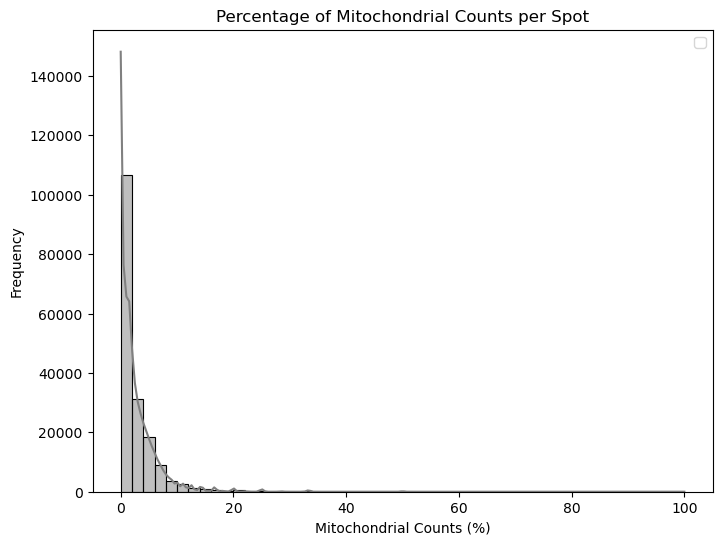

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(sdata_visium_hd["square_016um"].obs["pct_counts_mt"], kde=True, bins=50, color="gray")
# plt.axvline(20, color="red", linestyle="--", label="Threshold (20%)")
plt.title("Percentage of Mitochondrial Counts per Spot")
plt.xlabel("Mitochondrial Counts (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 2. Total counts

In [13]:
# List all available elements in the SpatialData object
print(sdata_visium_hd)

# Check if 'total_counts' exists in any table
if 'square_016um' in sdata_visium_hd.tables:
    print("Columns in 'square_016um':")
    print(sdata_visium_hd['square_016um'].obs.columns)

SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (7111371, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (678597, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (175483, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (7111371, 32285)
      ├── 'square_008um': AnnData (678597, 32285)
      └── 'square_016um': AnnData (175483, 32285)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes), Visium_HD_Mouse_Small_Intestine_square_016um (Shapes)
    ▸ 'downscaled_lowre

/tmp/ipykernel_129213/3325754802.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


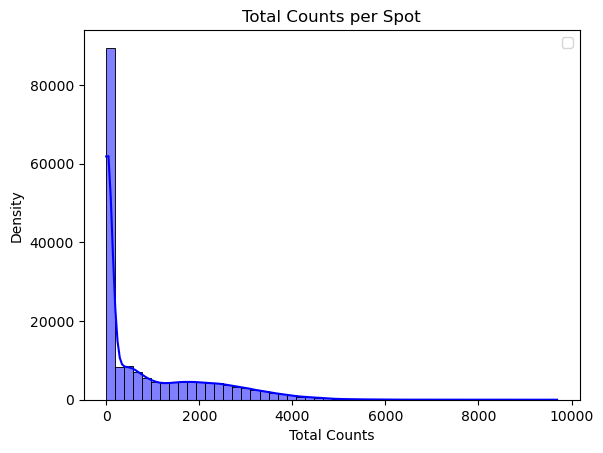

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Access the 'total_counts' column from the appropriate table
total_counts = sdata_visium_hd['square_016um'].obs['total_counts']

# Define a threshold for low library size (adjust as necessary)
# low_library_size_threshold = 1000  # Example threshold

# Plot the histogram
sns.histplot(total_counts, kde=True, bins=50, color='blue')
# plt.axvline(low_library_size_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Total Counts per Spot')
plt.xlabel('Total Counts')
plt.ylabel('Density')
plt.legend()
plt.show()

In [61]:
# Loop through all bin sizes in the SpatialData object
for bin_size in ["square_002um", "square_008um", "square_016um"]:
    print(f"\nProcessing bin size: {bin_size}")
    
    # Access the AnnData object for the current bin size
    adata = sdata_visium_hd[bin_size]
    
    # Access the 'total_counts' column
    if 'total_counts' in adata.obs.columns:
        total_counts = adata.obs['total_counts']
        
        # Display basic statistics for total counts
        print("Basic statistics for total counts per spot:")
        print(total_counts.describe())
        
        # Check the number of spots below a certain threshold
        low_library_size_threshold = 1000  # Example threshold
        low_library_spots = total_counts[total_counts < low_library_size_threshold]
        print(f"Number of spots below the threshold of {low_library_size_threshold}: {len(low_library_spots)}")
        print("Example spots with low total counts:")
        print(low_library_spots.head())
    else:
        print(f"'total_counts' column not found for bin size {bin_size}. Skipping.")


Processing bin size: square_002um
Basic statistics for total counts per spot:
count    7.111371e+06
mean     2.137656e+01
std      2.664677e+01
min      0.000000e+00
25%      3.000000e+00
50%      1.200000e+01
75%      3.000000e+01
max      6.740000e+02
Name: total_counts, dtype: float64
Number of spots below the threshold of 1000: 7111371
Example spots with low total counts:
s_002um_00000_00008-1    1.0
s_002um_00000_00013-1    1.0
s_002um_00000_00014-1    1.0
s_002um_00000_00015-1    2.0
s_002um_00000_00025-1    1.0
Name: total_counts, dtype: float32

Processing bin size: square_008um
Basic statistics for total counts per spot:
count    678597.000000
mean        224.015961
std         311.995819
min           0.000000
25%           4.000000
50%          47.000000
75%         377.000000
max        3055.000000
Name: total_counts, dtype: float64
Number of spots below the threshold of 1000: 658513
Example spots with low total counts:
s_008um_00000_00000-1    1.0
s_008um_00000_00002-1   

### 3. Genes

/tmp/ipykernel_129213/31817896.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


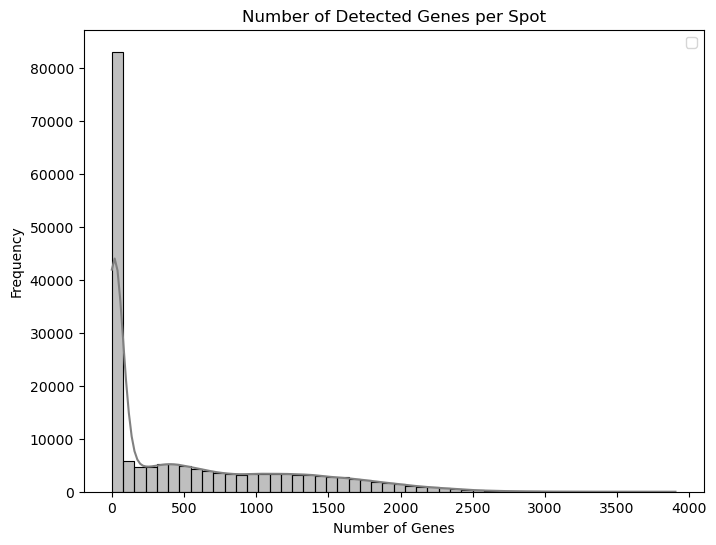

In [62]:
plt.figure(figsize=(8, 6))
sns.histplot(sdata_visium_hd["square_016um"].obs["n_genes_by_counts"], kde=True, bins=50, color="gray")
plt.title("Number of Detected Genes per Spot")
plt.xlabel("Number of Genes")
plt.ylabel("Frequency")
# plt.axvline(500, color="red", linestyle="--", label="Threshold (500 genes)")
plt.legend()
plt.show()

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.
CPU times: user 45.1 s, sys: 7.93 s, total: 53 s
Wall time: 53.2 s


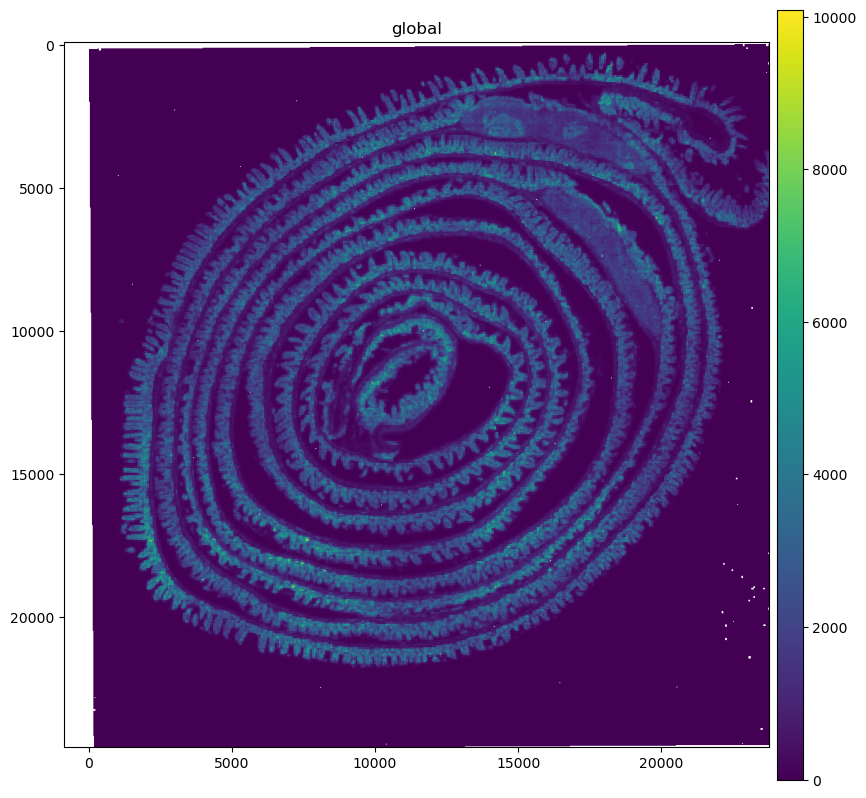

In [63]:
%%time
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot library size (total counts) using the spatial data plotting method
sdata_visium_hd.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um",
    color="total_counts",  # Use total_counts for library size
    method="datashader"    # Efficient rendering for large datasets
).pl.show(
    coordinate_systems="global",
    ax=ax
)

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


Text(0.5, 1.0, 'Percentage of Mitochondrial Reads')

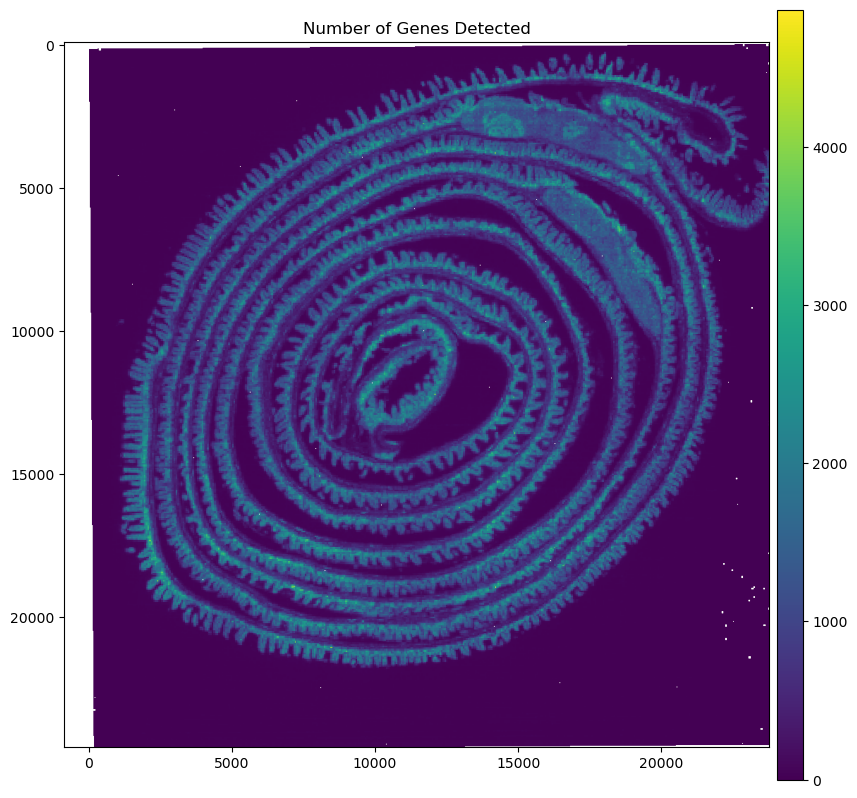

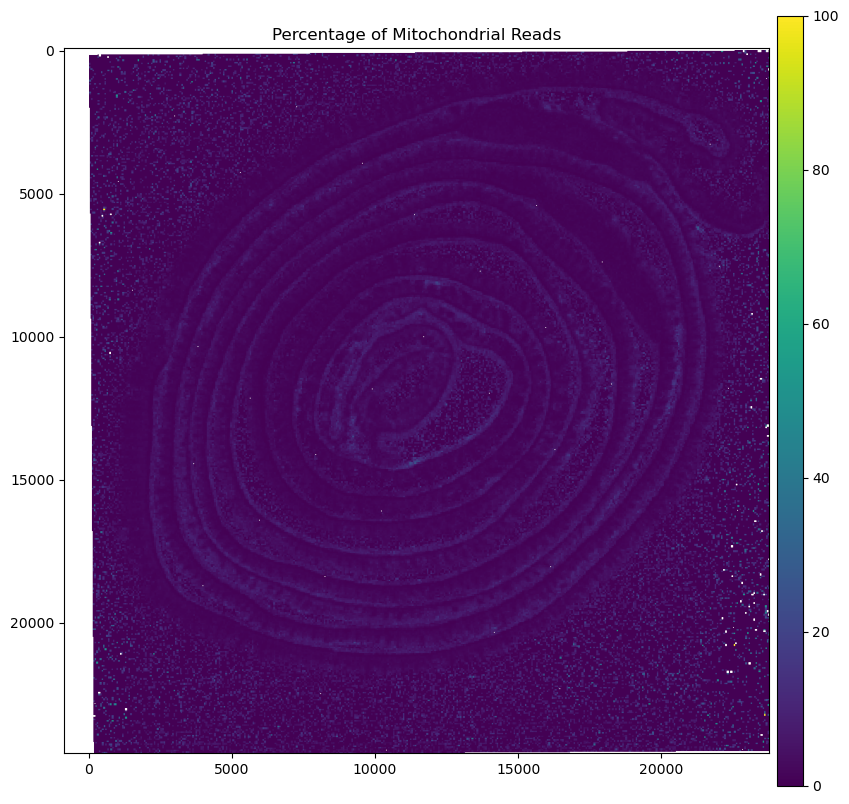

In [64]:
import matplotlib.pyplot as plt

# Plot number of genes detected (n_genes_by_counts)
plt.figure(figsize=(10, 10))
ax = plt.gca()
sdata_visium_hd.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um",
    color="n_genes_by_counts",  # Column for number of genes detected
    method="datashader"
).pl.show(
    coordinate_systems="global",
    ax=ax
)
plt.title("Number of Genes Detected")

# Plot mitochondrial content (pct_counts_mt)
plt.figure(figsize=(10, 10))
ax = plt.gca()
sdata_visium_hd.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um",
    color="pct_counts_mt",  # Column for mitochondrial percentage
    method="datashader"
).pl.show(
    coordinate_systems="global",
    ax=ax
)
plt.title("Percentage of Mitochondrial Reads")


In [65]:
import pandas as pd

# Define bin sizes and corresponding keys
bin_sizes = ["square_002um", "square_008um", "square_016um"]
metrics = {}

# Extract metrics for each bin size
for bin_size in bin_sizes:
    adata = sdata_visium_hd[bin_size]
    metrics[bin_size] = pd.DataFrame({
        "total_counts": adata.obs["total_counts"],
        "n_genes_by_counts": adata.obs["n_genes_by_counts"],
        "pct_counts_mt": adata.obs["pct_counts_mt"],
    })

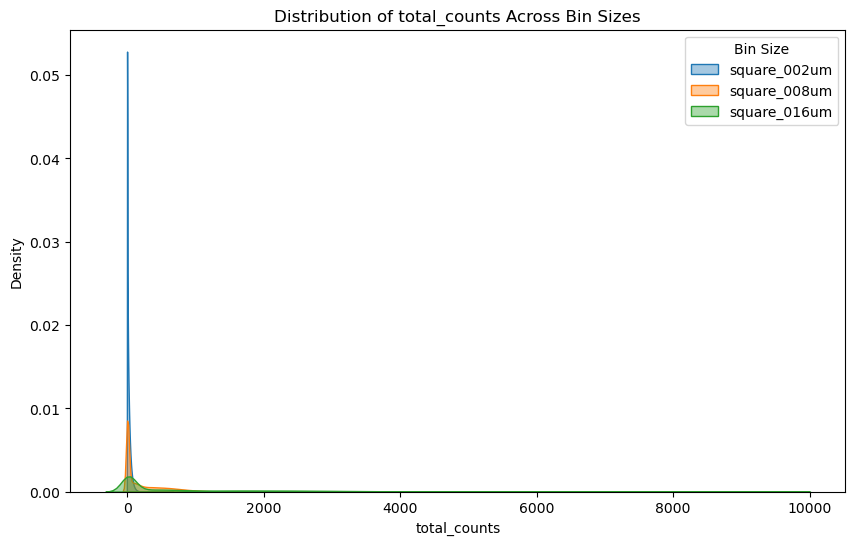

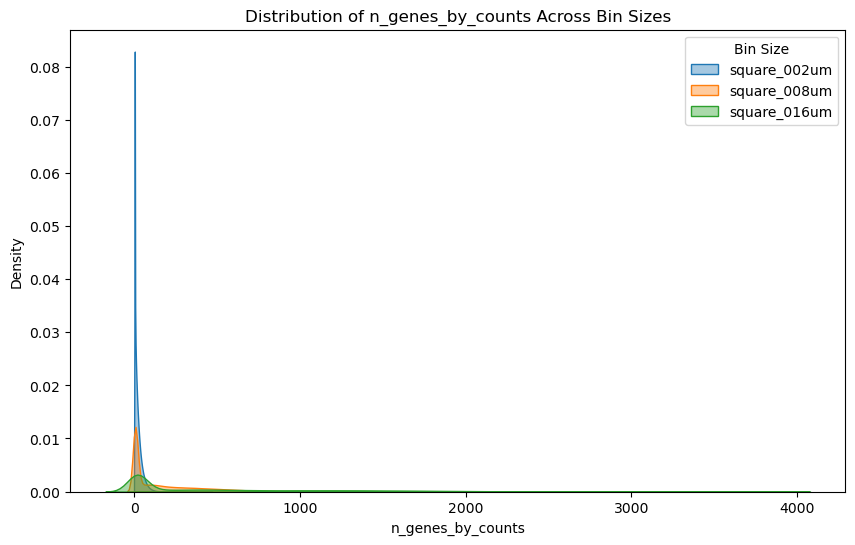

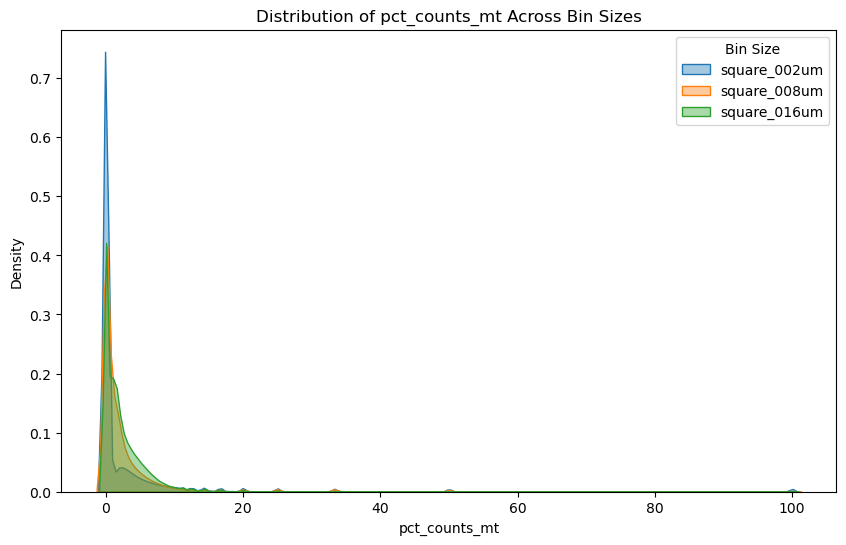

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

for metric in ["total_counts", "n_genes_by_counts", "pct_counts_mt"]:
    plt.figure(figsize=(10, 6))
    for bin_size in bin_sizes:
        sns.kdeplot(metrics[bin_size][metric], label=bin_size, fill=True, alpha=0.4)
    plt.title(f"Distribution of {metric} Across Bin Sizes")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend(title="Bin Size")
    plt.show()

/tmp/ipykernel_129213/1597494356.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x="bin_size", y="total_counts", palette="Set2")


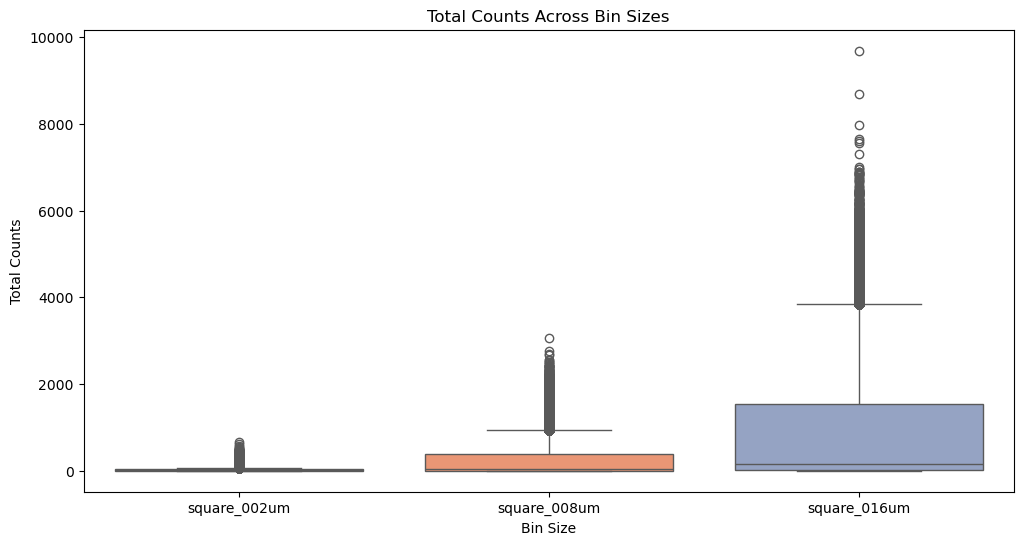

In [67]:
# Combine data for boxplot
combined_data = pd.concat(
    [metrics[bin_size].assign(bin_size=bin_size) for bin_size in bin_sizes]
)

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data, x="bin_size", y="total_counts", palette="Set2")
plt.title("Total Counts Across Bin Sizes")
plt.xlabel("Bin Size")
plt.ylabel("Total Counts")
plt.show()

In [68]:
for metric in ["total_counts", "n_genes_by_counts", "pct_counts_mt"]:
    print(f"Variance of {metric} across bin sizes:")
    for bin_size in bin_sizes:
        variance = metrics[bin_size][metric].var()
        print(f"  {bin_size}: {variance:.2f}")

Variance of total_counts across bin sizes:
  square_002um: 710.05
  square_008um: 97341.38
  square_016um: 1390420.75
Variance of n_genes_by_counts across bin sizes:
  square_002um: 513.89
  square_008um: 47269.61
  square_016um: 426204.75
Variance of pct_counts_mt across bin sizes:
  square_002um: 76.92
  square_008um: 42.12
  square_016um: 12.94


<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">QC across bins</span>  
<ul>
    <li>Are you seeing differences across bins?</li>

</div>

Let's remove:

In [8]:
sdata_visium_hd

SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (7111371, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (678597, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (175483, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (7111371, 32285)
      ├── 'square_008um': AnnData (678597, 32285)
      └── 'square_016um': AnnData (175483, 32285)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes), Visium_HD_Mouse_Small_Intestine_square_016um (Shapes)
    ▸ 'downscaled_lowre

## Remove cells

Below, some indicative filtering (please change based on more accurate observation of QCs)

In [14]:
# Define thresholds for filtering
mito_threshold = 20  # Maximum percentage of mitochondrial genes allowed
min_counts = 500  # Minimum total counts per spot
max_counts = 50000  # Maximum total counts per spot
min_genes = 200  # Minimum number of genes detected per spot

# Apply filters to the data
filtered_spots = (
    (sdata_visium_hd['square_016um'].obs['pct_counts_mt'] < mito_threshold) &
    (sdata_visium_hd['square_016um'].obs['total_counts'] > min_counts) &
    (sdata_visium_hd['square_016um'].obs['total_counts'] < max_counts) &
    (sdata_visium_hd['square_016um'].obs['n_genes_by_counts'] > min_genes)
)

# Subset the dataset to keep only high-quality spots
sdata_visium_hd['square_016um'] = sdata_visium_hd['square_016um'][filtered_spots]

# Confirm filtering results
print("After filtering:")
print(f"Number of spots retained: {sdata_visium_hd['square_016um'].n_obs}")
print(f"Number of genes retained: {sdata_visium_hd['square_016um'].n_vars}")

After filtering:
Number of spots retained: 72927
Number of genes retained: 32285


/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [15]:
sdata_visium_hd

SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (7111371, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (678597, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (175483, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (7111371, 32285)
      ├── 'square_008um': AnnData (678597, 32285)
      └── 'square_016um': AnnData (72927, 32285)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes), Visium_HD_Mouse_Small_Intestine_square_016um (Shapes)
    ▸ 'downscaled_lowres

<div style="border: 1px solid #ffa6a6; padding: 10px; border-radius: 5px;">
<span style="color: #ff6666; font-size: 20px;"><b>Reflection Point:</b></span> <span style="font-size: 20px;">Last challenge</span>  
<ul>
    <li>Can you make the following code work for Visium HD?</li>

</div>

## Normalisation

In [17]:
sadata = sdata_visium_hd["square_016um"]

In [18]:
sadata

View of AnnData object with n_obs × n_vars = 72927 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [ ]:
# Define normalization methods
normalization_methods = {
    "Raw Counts": sadata.copy(),
    "Normalize Total (default)": sadata.copy(),
    "Exclude Highly Expressed": sadata.copy(),
    "SCTransform": sadata.copy(),
    "Log-Normalization": sadata.copy(),
    "Quantile Normalization": sadata.copy(),
}

# Apply normalization methods
# 1. Normalize Total (default)
sc.pp.normalize_total(normalization_methods["Normalize Total (default)"], target_sum=1e6)

# 2. Exclude Highly Expressed
sc.pp.normalize_total(
    normalization_methods["Exclude Highly Expressed"], target_sum=1e6, exclude_highly_expressed=True
)

# 3. SCTransform
try:
    sc.experimental.pp.normalize_pearson_residuals(normalization_methods["SCTransform"])
except RuntimeWarning:
    sc.pp.filter_genes(normalization_methods["SCTransform"], min_counts=1)  # Filter out zero-count genes
    sc.experimental.pp.normalize_pearson_residuals(normalization_methods["SCTransform"])

# 4. Log-Normalization
sc.pp.log1p(normalization_methods["Log-Normalization"])

# 5. Quantile Normalization
quantile_sadata = normalization_methods["Quantile Normalization"]
quantile_sadata.X = pd.DataFrame(quantile_sadata.X.toarray()).rank(method="average", axis=0).to_numpy()

/opt/conda/envs/p2_sequence_based/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## HVG

In [ ]:
for method, sadata in normalization_methods.items():
    if method in ["Raw Counts", "Quantile Normalization"]:  # Skip Raw Counts and Quantile Normalization
        print(f"Skipping {method} due to data issues or unsuitability for HVG detection.")
        continue

    print(f"Processing {method}:")

    # Step 1: Filter out genes with near-zero mean expression
    if issparse(sadata.X):  # Handle sparse matrices
        gene_filter = sadata.X.mean(axis=0).A1 > 1e-12
    else:  # Dense matrices
        gene_filter = sadata.X.mean(axis=0) > 1e-12
    sadata = sadata[:, gene_filter]  # Filter genes

    # Step 2: Identify highly variable genes
    sc.pp.highly_variable_genes(
        sadata,
        flavor="cell_ranger",  # Use cell_ranger flavor for robust HVG detection
        n_top_genes=int(0.1 * sadata.shape[1]),  # Top 10% HVGs
        subset=False  # Do not subset the data yet
    )

    # Step 3: Display the number of HVGs
    hvg_count = sadata.var["highly_variable"].sum()
    print(f"Number of Highly Variable Genes for {method}: {hvg_count}")

    # Step 4: Get the top 20 HVGs by dispersion
    top_20_hvgs = sadata.var[sadata.var["highly_variable"]].sort_values(
        by="dispersions_norm", ascending=False
    ).head(20)
    print(f"Top 20 Highly Variable Genes for {method}:")
    print(top_20_hvgs.index.tolist())

    # Step 5: Plot HVGs manually
    plt.figure(figsize=(10, 6))
    plt.scatter(
        sadata.var["means"], sadata.var["dispersions_norm"], alpha=0.6, s=10, label="All Genes"
    )
    plt.scatter(
        top_20_hvgs["means"], top_20_hvgs["dispersions_norm"], color="red", label="Top 20 HVGs"
    )

    # Annotate the top 20 HVGs
    for gene in top_20_hvgs.index:
        mean = top_20_hvgs.loc[gene, "means"]
        disp = top_20_hvgs.loc[gene, "dispersions_norm"]
        plt.text(mean, disp, gene, fontsize=8, alpha=0.75)

    plt.xlabel("Mean Expression")
    plt.ylabel("Normalized Dispersion")
    plt.title(f"HVGs - {method}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Step 6: Print top 20 genes for clarity
    print(f"Top 20 HVGs for {method} (printed as a list):")
    for i, gene in enumerate(top_20_hvgs.index.tolist(), start=1):
        print(f"{i}. {gene}")
    print("-" * 50)

## Dimensionality Reduction

In [ ]:
# Initialize the results dictionary
umap_results = {}

for method, sadata in normalization_methods.items():
    print(f"Processing normalization method: {method}")
    
    # Step 1: Compute PCA
    sc.tl.pca(sadata)  # Ensure at least 10 PCs for neighbors calculation
    sadata.obsm['X_pca'] = sadata.obsm['X_pca'][:, :2]  # Keep the first two PCs for visualization
    
    # Step 2: Compute neighbors
    sc.pp.neighbors(sadata, n_neighbors=15)  # Adjust `n_neighbors` and `n_pcs` as needed
    
    # Step 3: Compute clustering (Leiden)
    sc.tl.leiden(sadata, resolution=0.2)  # Adjust resolution for desired granularity
    
    # Step 4: Compute UMAP
    sc.tl.umap(sadata)
    
    # Step 5: Store PCA, UMAP results, and clusters
    umap_results[method] = {
        'pca': sadata.obsm['X_pca'],
        'umap': sadata.obsm['X_umap'],
        'clusters': sadata.obs['leiden']
    }
    
    # Step 6: Plot PCA
    plt.figure(figsize=(6, 6))
    plt.scatter(sadata.obsm['X_pca'][:, 0], sadata.obsm['X_pca'][:, 1],
                c=sadata.obs['leiden'].astype(int), cmap='tab20', s=10, alpha=0.8)
    plt.title(f"PCA Clustering ({method})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label="Cluster")
    plt.show()
    
    # Step 7: Plot UMAP
    sc.pl.umap(
        sadata,
        color="leiden",
        title=f"UMAP Clustering ({method})",
        show=False,
        legend_loc='on data'
    )
    plt.show()
    
    # Step 8: Plot spatial clustering if spatial data is available
    if "spatial" in sadata.uns:
        sc.pl.spatial(
            sadata,
            img_key="hires",
            color="leiden",
            size=1.5,
            title=f"Spatial Clustering ({method})"
        )
    
    # Ensure variable names are unique
    sadata.var_names_make_unique()
    
    # Step 9: Identify cluster-specific marker genes
    sc.tl.rank_genes_groups(sadata, groupby="leiden", method="t-test")  # Adjust method if needed
    
    # Step 10: Plot a heatmap for a specific cluster
    cluster_to_plot = "9"  # Specify the cluster of interest
    print(f"Plotting heatmap for cluster {cluster_to_plot} ({method})...")
    sc.pl.rank_genes_groups_heatmap(
        sadata,
        groups=cluster_to_plot,
        n_genes=10,  # Number of top genes to display
        groupby="leiden",
        show=False
    )
    plt.title(f"Top Marker Genes for Cluster {cluster_to_plot} ({method})")
    plt.show()